In [ ]:
import re
import pickle
import math
import random as rd
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from tokenizers import Tokenizer,models,trainers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import torch
from torch.utils.data import DataLoader,Dataset,random_split

In [ ]:
lenta_news = pd.read_csv('lenta_news.csv')
lenta_news

,title,text,topic
0,МВД создало бюро по борьбе с отмыванием денег,В МВД России создано оперативно-розыскное бюро...,Экономика
1,Правительство не будет занимать деньги у ЦБ,Правительство не будет прибегать к заимствован...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Компания Boeing получит пятилетний контракт на...,Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Результаты конкурса на право освоения месторож...,Экономика
4,Неимущим для получения пособия придется расста...,В доходах малоимущих россиян будут учитываться...,Экономика
...,...,...,...
23944,"Борис Гребенщиков награжден орденом ""За заслуг...","Лидер легендарной группы ""Аквариум"" Борис Греб...",Культура
23945,Мадонна и Траволта названы худшими актерами года,"24 марта, накануне вручения премии Американско...",Культура
23946,Габриэль Гарсиа Маркес простил Голливуд ради д...,Габриэль Гарсиа Маркес,Культура
23947,Аль Пачино отстоял в суде свое право на детей,Знаменитый американский актер Аль Пачино добил...,Культура


In [ ]:
rbk_news = pd.read_csv('rbk_news.csv',header = None)
rbk_news

,0,1
0,США обеспокоены участием военных КНДР в военно...,Политика
1,"Пхеньян, по ее словам «не помогает» в урегулир...",Политика
2,США «по-прежнему обеспокоены прямым участием» ...,Политика
3,«Переброска на территорию России военных [КНДР...,Политика
4,\n\n\n\n\n\n\n Минобороны п...,Политика
...,...,...
1170,\n\n\n\n\n\n\n ЦБ подумает ...,Финансы
1171,В отличие от стратегий автоследования в ОПИФе ...,Финансы
1172,\n\n\n\n\n\n\n Индекс Мосби...,Финансы
1173,Идею привлечения авторов инвестиционных блогов...,Финансы


In [ ]:
rbk_news.iloc[:,1].unique()

array(['Политика', 'Экономика', 'Бизнес', 'Технологии и медиа', 'Финансы'],
      dtype=object)

In [ ]:
lenta_news.iloc[:,2].unique()

array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура'], dtype=object)

In [ ]:
rbk_news.loc[rbk_news[1] == 'Технологии и медиа',1] = 'Интернет и СМИ'

In [ ]:
rbk_news[1].unique()

array(['Политика', 'Экономика', 'Бизнес', 'Интернет и СМИ', 'Финансы'],
      dtype=object)

In [ ]:
lenta_news.iloc[:,2].unique()

array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура'], dtype=object)

In [ ]:
all_classes = list(set(rbk_news[1].unique().tolist() + lenta_news.iloc[:,2].unique().tolist()))

In [ ]:
print(len(all_classes))
all_classes

7


['Экономика',
 'Бизнес',
 'Финансы',
 'Культура',
 'Интернет и СМИ',
 'Спорт',
 'Политика']

In [ ]:
lent_text_col = pd.DataFrame({'Text':[lenta_news.iloc[row,0]+ ' ' +lenta_news.iloc[row,1] for row in range(len(lenta_news))]})

In [ ]:
lenta_news.insert(loc = 0,column = 'Text',value = lent_text_col['Text'])

In [ ]:
lenta_news.drop(['title','text'],axis = 1,inplace = True)

In [ ]:
lenta_news

,Text,topic
0,МВД создало бюро по борьбе с отмыванием денег ...,Экономика
1,Правительство не будет занимать деньги у ЦБ Пр...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Экономика
4,Неимущим для получения пособия придется расста...,Экономика
...,...,...
23944,"Борис Гребенщиков награжден орденом ""За заслуг...",Культура
23945,Мадонна и Траволта названы худшими актерами го...,Культура
23946,Габриэль Гарсиа Маркес простил Голливуд ради д...,Культура
23947,Аль Пачино отстоял в суде свое право на детей ...,Культура


In [ ]:
rbk_news.columns = ['Text','topic']

In [ ]:
rbk_news

,Text,topic
0,США обеспокоены участием военных КНДР в военно...,Политика
1,"Пхеньян, по ее словам «не помогает» в урегулир...",Политика
2,США «по-прежнему обеспокоены прямым участием» ...,Политика
3,«Переброска на территорию России военных [КНДР...,Политика
4,\n\n\n\n\n\n\n Минобороны п...,Политика
...,...,...
1170,\n\n\n\n\n\n\n ЦБ подумает ...,Финансы
1171,В отличие от стратегий автоследования в ОПИФе ...,Финансы
1172,\n\n\n\n\n\n\n Индекс Мосби...,Финансы
1173,Идею привлечения авторов инвестиционных блогов...,Финансы


In [ ]:
print(rbk_news.columns)
print(lenta_news.columns)
rbk_news.columns == lenta_news.columns

Index(['Text', 'topic'], dtype='object')
Index(['Text', 'topic'], dtype='object')


array([ True,  True])

In [ ]:
all_news_data = pd.concat([lenta_news,rbk_news],axis = 0,ignore_index=True)

In [ ]:
all_news_data

,Text,topic
0,МВД создало бюро по борьбе с отмыванием денег ...,Экономика
1,Правительство не будет занимать деньги у ЦБ Пр...,Экономика
2,"ВВС США заказали 60 ""Боингов"" для вторжения в ...",Экономика
3,Правительственная комиссия не дала ExxonMobil ...,Экономика
4,Неимущим для получения пособия придется расста...,Экономика
...,...,...
25119,\n\n\n\n\n\n\n ЦБ подумает ...,Финансы
25120,В отличие от стратегий автоследования в ОПИФе ...,Финансы
25121,\n\n\n\n\n\n\n Индекс Мосби...,Финансы
25122,Идею привлечения авторов инвестиционных блогов...,Финансы


In [ ]:
labels = all_news_data['topic'].unique()
print(len(labels))
labels

7


array(['Экономика', 'Интернет и СМИ', 'Спорт', 'Культура', 'Политика',
       'Бизнес', 'Финансы'], dtype=object)

In [ ]:
all_news_data.to_csv('all_news_data.csv')

In [ ]:
for one_label in labels:
    the_one = all_news_data.loc[all_news_data['topic'] == one_label,'Text'].iloc[rd.randint(0,300)]
    print(one_label)
    print(the_one)
    print('\n\n')

Экономика
Касьянов заинтересовал Словакию новым газопроводом Словацкая сторона проявила "заметный интерес" к идее строительства газопровода по своей территории для транспортировки российского газа в Европу, об этом заявлено на встрече премьер-министра РФ Михаила Касьянова и министра экономики Словакии Любомира Гараха в среду в московском Доме правительства. Как сообщают из Департамента правительственной информации, Словакия уже заявила, что придает большое значение этому проекту, который свяжет магистральные газопроводы на территории Словакии и Польши. Сооружение новой нитки газопровода через Словакию позволит направить российский газ с Ямала в Европу в обход Украины, которая продолжает прибегать к несанкционированным заборам российского газа. Потери России от действий Украины оцениваются в несколько миллиардов кубических  метров в год. Беседа Касьянова и Гараха состоялась в рамках обсуждения итогов прошедшего накануне заседания российско-словацкой межправительственной комиссии по науч

In [ ]:
all_news = pd.read_csv('all_news_data.csv',index_col = 0)

In [ ]:
Train_news,Test_news = train_test_split(all_news,stratify=all_news['topic'],train_size=0.93)

In [ ]:
print(len(Train_news))
print(len(Test_news))

23365
1759


In [ ]:
# Train_news.to_csv('Train_news.csv')
# Test_news.to_csv('Test_news.csv')

In [ ]:
Train_news,Test_news = pd.read_csv('Train_news.csv',index_col=0),pd.read_csv('Test_news.csv',index_col=0)

In [ ]:
# Test_news = Test_news.reset_index().drop(['index'],axis = 1)
# Train_news = Train_news.reset_index().drop(['index'],axis = 1)

In [ ]:
print(len(Train_news))
print(len(Test_news))

23364
1759


In [ ]:
print(len(Train_news))
Train_news.iloc[:5,:]

23364


,Text,topic
0,"Украина готова вернуть ""взятый по ошибке"" кред...",Экономика
1,Рио-де-Жанейро стал кандидатом на роль столицы...,Спорт
2,Скончался драматург и сценарист Александр Воло...,Культура
3,Испанец пересек Атлантический океан на водном ...,Спорт
4,"Украина на Новый год останавливает все, что дв...",Интернет и СМИ


In [ ]:
print(len(Test_news))
Test_news.iloc[:5,:]

1759


,Text,topic
0,"Падение фондового рынка возглавили ""ЮКОС"" и ""Г...",Экономика
1,Контрабанда нефти из Ирака достигла рекордного...,Экономика
2,"Андрей Шевченко продлил контракт с ""Миланом"" д...",Спорт
3,Американцы запрещают детям играть в компьютерн...,Интернет и СМИ
4,Napster идет маршем на Вашингтон Napster призы...,Интернет и СМИ


In [ ]:
len(Test_news)

1759

In [ ]:
len(Test_news.dropna())

1759

In [ ]:
# Train_news.dropna(inplace=True)
# Train_news.reset_index().drop('index',axis = 1,inplace = True)

In [ ]:
# Train_news.to_csv('Train_news.csv')

In [ ]:
russian_stopwords = stopwords.words('russian')
print(len(russian_stopwords))
russian_stopwords[:10]

151


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
def normalize_text(the_text):
    lowered = the_text.lower()
    found = re.findall(r'[А-я0-9A-z]+',lowered)
    filtered_found = [word for word in found if word != '' and word not in russian_stopwords]
    return filtered_found

In [ ]:
example_text = Train_news.iloc[3,0]
example_text

'Испанец пересек Атлантический океан на\xa0водном мотоцикле Испанец Альваро де Маричалар (Alvaro de Marichalar) пересек Атлантический океан на водном мотоцикле, сообщает в воскресенье BBC News. Маричалар начал свое путешествие четыре месяца в Риме. Проплыв по реке Тибр до Средиземного моря, он делал остановки в Марокко, на Гибралтаре и на Канарских островах. Достигнув Атлантического океана, путешественник посетил Кубу и в Доминиканскую республику. Конечной точкой маршрута Маричалара стал Майами, США. Маричалар ехал 12 часов в сутки. На протяжении всего маршрута его сопровождало судно с командой из шести человек на борту, которое перевозило еду и топливо для водного мотоцикла. По словам испанца, он потратил на подготовку к путешествию несколько лет, и поправился на 18 килограмм, чтобы компенсировать потерю веса во время прохождения маршрута. Отвечая на вопрос журналистов, что было самым тяжелым во время пересечения Атлантического океана, Маричалар ответил: "Холод. По дороге из Рима в Не

In [ ]:
def cleared_texts(text_col):
    for ith_row in range(len(text_col)):
        for token in normalize_text(text_col.iloc[ith_row]):
            yield token

In [ ]:
tokens_dataset = cleared_texts(Train_news['Text'])

In [ ]:
wordlevel_trainer = trainers.WordLevelTrainer(vocab_size = 500_000,show_progress = True,special_tokens = ['[UNK]','[PAD]'],min_frequency = 5)
wordlevel_model = models.WordLevel()
Train_tokenizer = Tokenizer(model = wordlevel_model)

In [ ]:
Train_tokenizer.train_from_iterator(tokens_dataset,trainer=wordlevel_trainer)

In [ ]:
# Train_tokenizer.get_vocab_size()

57568

In [ ]:
# with open('Train_tokenizer.pkl','wb') as file:
#     pickle.dump(Train_tokenizer,file)

In [ ]:
with open('Train_tokenizer.pkl','rb') as file:
    Train_tokenizer = pickle.load(file)

In [ ]:
Train_tokenizer.get_vocab_size()

57568

In [ ]:
test_tokens_dataset = cleared_texts(Test_news['Text'])

In [ ]:
wordlevel_trainer = trainers.WordLevelTrainer(vocab_size = 500_000,show_progress = True,special_tokens = ['[UNK]','[PAD]'])
wordlevel_model = models.WordLevel()
Test_tokenizer = Tokenizer(model = wordlevel_model)

In [ ]:
Test_tokenizer.train_from_iterator(test_tokens_dataset,trainer=wordlevel_trainer)

In [ ]:
Test_tokenizer.get_vocab_size()

51219

In [ ]:
# with open('Test_tokenizer.pkl','wb') as file:
#     pickle.dump(Test_tokenizer,file)

In [ ]:
#loading main functions
def normalize_text(the_text):
    lowered = the_text.lower()
    found = re.findall(r'[А-я0-9A-z]+',lowered)
    filtered_found = [word for word in found if word != '' and word not in russian_stopwords]
    return filtered_found


def cleared_texts(text_col):
    for ith_row in range(len(text_col)):
        for token in normalize_text(text_col.iloc[ith_row]):
            yield token


russian_stopwords = stopwords.words('russian')
print(len(russian_stopwords))
russian_stopwords[:10]

151


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
#loading datasets
Train_news,Test_news = pd.read_csv('Train_news.csv',index_col=0),pd.read_csv('Test_news.csv',index_col=0)

In [ ]:
#loading saved tokenizers
with open('Train_tokenizer.pkl','rb') as file:
    Train_tokenizer = pickle.load(file)

with open('Test_tokenizer.pkl','rb') as file:
    Test_tokenizer = pickle.load(file)

In [ ]:
Train_news.iloc[:3,0]

0    Украина готова вернуть "взятый по ошибке" кред...
1    Рио-де-Жанейро стал кандидатом на роль столицы...
2    Скончался драматург и сценарист Александр Воло...
Name: Text, dtype: object

In [ ]:
Test_news.iloc[:3,0]

0    Падение фондового рынка возглавили "ЮКОС" и "Г...
1    Контрабанда нефти из Ирака достигла рекордного...
2    Андрей Шевченко продлил контракт с "Миланом" д...
Name: Text, dtype: object

In [ ]:
print(Test_tokenizer.get_vocab_size())
print(Train_tokenizer.get_vocab_size())

51219
57568


In [ ]:
#train the embeddings (3 types)
#n_grams
embd_training_text_list = list(cleared_texts(Train_news['Text']))
embd_test_text_list = list(cleared_texts(Test_news['Text']))

In [ ]:
print(embd_training_text_list[:5])
print(embd_test_text_list[:5])

['украина', 'готова', 'вернуть', 'взятый', 'ошибке']
['падение', 'фондового', 'рынка', 'возглавили', 'юкос']


In [ ]:
def create_n_grams(list_of_tokens,window_size):
    '''creates N-grams with specified window'''
    for ind in range(window_size,len(list_of_tokens)-window_size):
        n_grams = []
        #adding the words in window to the list
        for window_gap in range(1,window_size + 1):
            n_grams.append(list_of_tokens[ind - window_gap])
        for window_gap in range(1,window_size + 1):
            n_grams.append(list_of_tokens[ind + window_gap])
        #yielding the result so that we can save some memory)
        yield n_grams,list_of_tokens[ind]

In [ ]:
train_n_grams = create_n_grams(embd_training_text_list,window_size=2)
test_n_grams = create_n_grams(embd_test_text_list,window_size=2)

In [ ]:
#example
print(next(train_n_grams))
print(next(train_n_grams))
print(next(train_n_grams))

(['готова', 'украина', 'взятый', 'ошибке'], 'вернуть')
(['вернуть', 'готова', 'ошибке', 'кредит'], 'взятый')
(['взятый', 'вернуть', 'кредит', 'мвф'], 'ошибке')


In [ ]:
print(next(test_n_grams))
print(next(test_n_grams))
print(next(test_n_grams))

(['фондового', 'падение', 'возглавили', 'юкос'], 'рынка')
(['рынка', 'фондового', 'юкос', 'газпром'], 'возглавили')
(['возглавили', 'рынка', 'газпром', 'настоящее'], 'юкос')


In [ ]:
embd_test_text_list[:10]

['падение',
 'фондового',
 'рынка',
 'возглавили',
 'юкос',
 'газпром',
 'настоящее',
 'время',
 '16',
 '00']

In [ ]:
embd_training_text_list[:10]

['украина',
 'готова',
 'вернуть',
 'взятый',
 'ошибке',
 'кредит',
 'мвф',
 'украина',
 'готова',
 'вернуть']

In [ ]:
class NGramDataset(Dataset):
    def __init__(self,tokenizer,the_data):
        self.main_data = the_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.main_data)

    def __getitem__(self,indx):
        X = torch.tensor([self.tokenizer.token_to_id(word) if self.tokenizer.token_to_id(word) != None else self.tokenizer.token_to_id('[UNK]') for word in self.main_data[indx][0]],dtype=torch.long)
        true_word = self.main_data[indx][1]
        y = self.tokenizer.token_to_id(true_word) if self.tokenizer.token_to_id(true_word) != None else self.tokenizer.token_to_id('[UNK]')
        return X,y

In [ ]:
Train_Ngramsdataset = NGramDataset(Train_tokenizer,list(train_n_grams))

In [ ]:
#saving this dataset
# with open('/home/luchian/all_data/uni_data/Train_Ngramsdataset','wb') as file:
#     pickle.dump(Train_Ngramsdataset,file)

In [ ]:
#loading this dataset
with open('/home/luchian/all_data/uni_data/Train_Ngramsdataset','rb') as file:
    Train_Ngramsdataset = pickle.load(file)

In [ ]:
print(len(Train_Ngramsdataset))
print(Train_Ngramsdataset[339823])

3153657
(tensor([8481,   69,  670,  370]), 140)


In [ ]:
class NGramModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        #from both sides
        self.linear1 = nn.Linear(2*window_size*dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list)
        y = y.reshape(y.shape[0],-1)
        y = self.rel(self.linear1(y))
        y = self.linear2(y)
        return y

In [ ]:
#training
def train_ngram_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda'):
    for one_ep in range(epoch):
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

In [ ]:
#setting the model
vocab_size = Train_tokenizer.get_vocab_size()
ngram_model = NGramModel(vocab_size,dim_embed = 100,window_size = 2)
ngram_model.to(device = 'cuda')

NGramModel(
  (embed): Embedding(57568, 100)
  (linear1): Linear(in_features=400, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=57568, bias=True)
  (rel): ReLU()
)

In [ ]:
train_loader = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 24)
lr = 0.001
epoch = 10
optimizer = torch.optim.SGD(lr = lr,params= ngram_model.parameters(),momentum=0.02)
the_loss = nn.CrossEntropyLoss()

In [ ]:
#training ngrams models
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 630732/630732 [39:03<00:00, 269.19it/s]


Current Loss: 9.32483832654222


Going through the loader: 100%|██████████| 630732/630732 [39:00<00:00, 269.43it/s]


Current Loss: 8.641969712639877


Going through the loader: 100%|██████████| 630732/630732 [39:00<00:00, 269.45it/s]


Current Loss: 8.432383479773657


Going through the loader: 100%|██████████| 630732/630732 [39:02<00:00, 269.28it/s]


Current Loss: 8.273298127135142


Going through the loader: 100%|██████████| 630732/630732 [39:01<00:00, 269.41it/s]


Current Loss: 8.135015301765817


Going through the loader:  17%|█▋        | 105677/630732 [06:34<32:39, 267.90it/s]


KeyboardInterrupt: 

In [ ]:
optimizer.param_groups[0]['lr'] = 0.05

In [ ]:
optimizer.param_groups[0]['lr']

0.05

In [ ]:
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 630732/630732 [39:03<00:00, 269.17it/s]


Current Loss: 8.171061615305863


Going through the loader: 100%|██████████| 630732/630732 [38:53<00:00, 270.26it/s]


Current Loss: 7.468744769802325


Going through the loader: 100%|██████████| 630732/630732 [38:58<00:00, 269.73it/s]


Current Loss: 7.080750655115399


Going through the loader: 100%|██████████| 630732/630732 [38:56<00:00, 269.92it/s]


Current Loss: 6.818268371984311


Going through the loader: 100%|██████████| 630732/630732 [38:59<00:00, 269.59it/s]


Current Loss: 6.624463000038144


Going through the loader: 100%|██████████| 630732/630732 [38:58<00:00, 269.68it/s]


Current Loss: 6.471705604922975


Going through the loader: 100%|██████████| 630732/630732 [38:57<00:00, 269.79it/s]


Current Loss: 6.348056463583278


Going through the loader: 100%|██████████| 630732/630732 [38:59<00:00, 269.56it/s]


Current Loss: 6.244131233123362


Going through the loader: 100%|██████████| 630732/630732 [38:57<00:00, 269.82it/s]


Current Loss: 6.155822211073704


Going through the loader: 100%|██████████| 630732/630732 [39:00<00:00, 269.49it/s]

Current Loss: 6.0792385670027205


In [ ]:
epoch = 20
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.98it/s]


Current Loss: 5.519884179043307


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.83it/s]


Current Loss: 5.442827039329851


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.80it/s]


Current Loss: 5.413536088380986


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.20it/s]


Current Loss: 5.390498882853134


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.17it/s]


Current Loss: 5.370131912798847


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.06it/s]


Current Loss: 5.351071769359849


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.11it/s]


Current Loss: 5.333531328547933


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.11it/s]


Current Loss: 5.316638866926077


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.60it/s]


Current Loss: 5.300499587808625


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.91it/s]


Current Loss: 5.285289190922727


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.91it/s]


Current Loss: 5.270228960653361


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.28it/s]


Current Loss: 5.25600776868283


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.88it/s]


Current Loss: 5.242303302258789


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.52it/s]


Current Loss: 5.228750664615409


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.31it/s]


Current Loss: 5.215810238418262


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.26it/s]


Current Loss: 5.202770970433312


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.24it/s]


Current Loss: 5.190729383192025


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.41it/s]


Current Loss: 5.178503718572878


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.42it/s]


Current Loss: 5.167148923234867


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.29it/s]

Current Loss: 5.1553040912675465


In [ ]:
optimizer.param_groups[0]['lr'] = 0.1
optimizer.param_groups[0]['lr']

0.1

In [ ]:
epoch = 20
train_ngram_model(ngram_model,epoch,train_loader,optimizer,the_loss,dev = 'cuda')

Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.07it/s]


Current Loss: 5.344169051660087


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 244.87it/s]


Current Loss: 5.325969000098109


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.65it/s]


Current Loss: 5.304829706328518


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.29it/s]


Current Loss: 5.285560171995143


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.82it/s]


Current Loss: 5.2673491077421355


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.35it/s]


Current Loss: 5.250226574608237


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.20it/s]


Current Loss: 5.233648620168864


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.75it/s]


Current Loss: 5.217173271853868


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.33it/s]


Current Loss: 5.201587012839929


Going through the loader: 100%|██████████| 131403/131403 [08:56<00:00, 245.13it/s]


Current Loss: 5.186790356493399


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.30it/s]


Current Loss: 5.1721138142324135


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.61it/s]


Current Loss: 5.1579464965471455


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.30it/s]


Current Loss: 5.144093390611656


Going through the loader: 100%|██████████| 131403/131403 [08:54<00:00, 245.69it/s]


Current Loss: 5.130876923368022


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.56it/s]


Current Loss: 5.117994414570968


Going through the loader: 100%|██████████| 131403/131403 [08:55<00:00, 245.37it/s]


Current Loss: 5.105082858274955


Going through the loader: 100%|██████████| 131403/131403 [08:53<00:00, 246.44it/s]


Current Loss: 5.093274562882113


Going through the loader: 100%|██████████| 131403/131403 [08:52<00:00, 246.58it/s]


Current Loss: 5.080866250494819


Going through the loader: 100%|██████████| 131403/131403 [08:53<00:00, 246.43it/s]


Current Loss: 5.069270572151561


Going through the loader: 100%|██████████| 131403/131403 [08:52<00:00, 246.55it/s]

Current Loss: 5.057996065708434


In [ ]:
#total time is 201+2*178+389
# torch.save(ngram_model.state_dict(),'/home/luchian/all_data/uni_data/ngram_embeddings.pth')
# torch.save(optimizer.state_dict(),'/home/luchian/all_data/uni_data/optimizer_ngram_params.pth')
# ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_embeddings.pth',weights_only = True))
# optimizer.load_state_dict(torch.load('/home/luchian/all_data/uni_data/optimizer_ngram_params.pth',weights_only=True))

In [ ]:
#CBOW model
#we can use the same dataset here, but we just have to sum things up
class CBOWModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        self.linear = nn.Linear(1,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list).sum(dim = (1,2)).reshape(-1,1)
        y = self.rel(self.linear(y))
        return y

In [ ]:
#setting the model
vocab_size = Train_tokenizer.get_vocab_size()
cbow_model = CBOWModel(vocab_size,dim_embed = 100,window_size = 2)
cbow_model.to(device = 'cuda')

CBOWModel(
  (embed): Embedding(57568, 100)
  (linear): Linear(in_features=1, out_features=57568, bias=True)
  (rel): ReLU()
)

In [ ]:
train_cbow_loader = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 64)
lr = 0.001
epoch = 20
optimizer_cbow = torch.optim.SGD(lr = lr,params= cbow_model.parameters())
the_loss = nn.CrossEntropyLoss()

In [ ]:
def train_cbow_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda'):
    for one_ep in range(epoch):
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {the_losses[-1]}')

In [ ]:
train_cbow_model(cbow_model,epoch,train_cbow_loader,optimizer_cbow,the_loss)

Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.59it/s]


Current Loss: 9.356122016906738


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.60it/s]


Current Loss: 10.109236717224121


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.62it/s]


Current Loss: 9.097528457641602


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.65it/s]


Current Loss: 9.620772361755371


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.65it/s]


Current Loss: 9.99347972869873


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 9.907873153686523


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.64it/s]


Current Loss: 10.344832420349121


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 9.648063659667969


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 10.355978012084961


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.62it/s]


Current Loss: 9.652222633361816


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 9.432632446289062


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.73it/s]


Current Loss: 10.463277816772461


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 10.017885208129883


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.68it/s]


Current Loss: 9.411460876464844


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 10.048050880432129


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.69it/s]


Current Loss: 9.609384536743164


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.67it/s]


Current Loss: 9.471277236938477


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.66it/s]


Current Loss: 9.50818920135498


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.68it/s]


Current Loss: 9.563058853149414


Going through the loader: 100%|██████████| 49276/49276 [03:48<00:00, 215.62it/s]

Current Loss: 9.967806816101074


In [ ]:
# torch.save(cbow_model.state_dict(),'/home/luchian/all_data/uni_data/cbow_embeddings.pth')
# torch.save(optimizer_cbow.state_dict(),'/home/luchian/all_data/uni_data/cbow_optimizer.pth')

In [ ]:
#encoding labels (they have to be the same in the dataset below for test and for train)
unique_train_labels = Train_news['topic'].unique()
unique_test_labels = Test_news['topic'].unique()
print(set(unique_test_labels) == set(unique_train_labels),end = '\n\n')
print(type(unique_test_labels))
print(len(unique_test_labels))
print(unique_train_labels)
print(unique_test_labels)

True

<class 'numpy.ndarray'>
7
['Экономика' 'Спорт' 'Культура' 'Интернет и СМИ' 'Финансы' 'Бизнес'
 'Политика']
['Экономика' 'Спорт' 'Интернет и СМИ' 'Культура' 'Политика' 'Финансы'
 'Бизнес']


In [ ]:
le = preprocessing.LabelEncoder().fit(unique_train_labels)
print(le.classes_)
print(le.transform(['Экономика']).item())
print(le.transform(['Финансы']).item())

['Бизнес' 'Интернет и СМИ' 'Культура' 'Политика' 'Спорт' 'Финансы'
 'Экономика']
6
5


In [ ]:
print(Train_tokenizer.token_to_id('[UNK]'))
print(Train_tokenizer.token_to_id('[PAD]'))

0
1


In [ ]:
class Padding():
    def __init__(self,pad = 945,dtype = torch.long):
        self.pad = pad
        self.dtype = dtype
    def __call__(self,tens):
        ones = torch.ones(self.pad,dtype = self.dtype)
        for ind in range(tens.shape[0]):
            ones[ind] = tens[ind]
        return ones

In [ ]:
OnesPadding = Padding(5)

In [ ]:
some_tens = torch.tensor([1,2,3],dtype = torch.long)
some_tens

tensor([1, 2, 3])

In [ ]:
OnesPadding(some_tens)

tensor([1, 2, 3, 1, 1])

In [ ]:
#creating dataset for word indices and padding
class NewsDataset(Dataset):
    def __init__(self,the_data,le,tokenizer,transforms = None):
        self.main_data = the_data
        self.tokenizer = tokenizer
        self.label_encoder = le
        self.transforms = transforms

    def __len__(self):
        return len(self.main_data)

    def __getitem__(self,indx):
        X = [self.tokenizer.token_to_id(one_token) if self.tokenizer.token_to_id(one_token) != None else self.tokenizer.token_to_id('[UNK]') for one_token in normalize_text(self.main_data.iloc[indx,0])]
        y = self.label_encoder.transform([self.main_data.iloc[indx,1]]).item()
        return X,y

In [ ]:
TrainDataset = NewsDataset(Train_news,le,Train_tokenizer,transforms=None)

In [ ]:
len(TrainDataset[0][0])

129

In [ ]:
#find the maximum length of the sentence, so that we use the necessary padding here

In [ ]:
the_max_len_of_sents = 0
for one_item in TrainDataset:
    the_max_len_of_sents = max(the_max_len_of_sents,len(one_item[0]))

In [ ]:
the_max_len_of_sents

945

In [ ]:
TestDataset = NewsDataset(Test_news,le,Test_tokenizer,transforms=None)

In [ ]:
max_len_test = 0
for one_item in TestDataset:
    max_len_test = max(max_len_test,one_item[0].shape[0])

In [ ]:
max_len_test

625

In [ ]:
#THE MAIN Dataset
class NewsDataset(Dataset):
    def __init__(self,the_data,le,tokenizer,transforms = None):
        self.main_data = the_data
        self.tokenizer = tokenizer
        self.label_encoder = le
        self.transforms = transforms

    def __len__(self):
        return len(self.main_data)

    def __getitem__(self,indx):
        X = [self.tokenizer.token_to_id(one_token) if self.tokenizer.token_to_id(one_token) != None else self.tokenizer.token_to_id('[UNK]') for one_token in normalize_text(self.main_data.iloc[indx,0])]
        y = self.label_encoder.transform([self.main_data.iloc[indx,1]]).item()
        X,y = torch.tensor(X,dtype = torch.long),torch.tensor(y,dtype = torch.long)
        return (X,y) if self.transforms == None else (self.transforms(X),y)

In [ ]:
TrainDataset = NewsDataset(Train_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

In [ ]:
TestDataset = NewsDataset(Test_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

In [ ]:
#checking weather everything matches
for one_sample in TrainDataset:
    if one_sample[0].shape[0] != 945:
        print('SHORTER than it should be')

In [ ]:
Train_loader = DataLoader(dataset = TrainDataset,shuffle = True,batch_size = 32)
Train_loader

In [ ]:
Test_loader = DataLoader(dataset = TestDataset,shuffle = True,batch_size = 1)
Test_loader

In [ ]:
one_iter = next(iter(Test_loader))

In [ ]:
for X,y in Test_loader:
    X,y

In [ ]:
for X,y in Train_loader:
    X,y

In [ ]:
class NgramCNNMod(nn.Module):
    def __init__(self,vocab_size,dim_embed = 100,ker_sizes = [2,5,11]):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed,padding_idx=1)
        self.conv1 = nn.Conv2d(1,111,kernel_size=(ker_sizes[0],dim_embed))
        self.conv2 = nn.Conv2d(1,111,kernel_size=(ker_sizes[1],dim_embed))
        self.conv3 = nn.Conv2d(1,111,kernel_size=(ker_sizes[2],dim_embed))
        self.lin1 = nn.Linear(333,7)

        self.mp1 = nn.MaxPool1d(kernel_size=945-ker_sizes[0]+1)
        self.mp2 = nn.MaxPool1d(kernel_size=945-ker_sizes[1]+1)
        self.mp3 = nn.MaxPool1d(kernel_size=945-ker_sizes[2]+1)
        self.drop = nn.Dropout1d(p = 0.5)

        self.rel = nn.ReLU()

    def forward(self,inds_list):
        y = self.embed(inds_list)
        y = y.unsqueeze(dim = 1)

        y1 = self.rel(self.conv1(y))
        y2 = self.rel(self.conv2(y))
        y3 = self.rel(self.conv3(y))

        y1 = y1.squeeze(dim = -1)
        y2 = y2.squeeze(dim = -1)
        y3 = y3.squeeze(dim = -1)

        y1 = self.mp1(y1)
        y2 = self.mp2(y2)
        y3 = self.mp3(y3)

        y = torch.concat([y1,y2,y3],dim = -1)
        return y
        y = y.reshape(y.shape[0],-1)
        y = self.drop(y)
        y = self.rel(self.lin1(y))
        return y

In [ ]:
Test_model = NgramCNNMod(57568,100)

In [ ]:
import numpy as np
some_tens = torch.from_numpy(np.random.randint(1,101,size = (1,945)))

In [ ]:
Test_model(some_tens).shape

torch.Size([1, 111, 1])

In [ ]:
Test_model(some_tens).shape

torch.Size([1, 111, 3])

In [ ]:
ngramcnnmod = NgramCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=100,ker_sizes=[2,5,11])
ngramcnnmod.embed.weight = ngram_model.embed.weight
print(ngramcnnmod.embed)
ngramcnnmod.to(device = 'cuda')

Embedding(57568, 100, padding_idx=1)


NgramCNNMod(
  (embed): Embedding(57568, 100, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(5, 100), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(11, 100), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=935, stride=935, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [ ]:
ngramcnnmod.embed(torch.tensor([[1,2],[3,4]]).to(device = 'cuda')).shape

torch.Size([2, 2, 100])

In [ ]:
one_sample = next(iter(Train_loader))[0].to(device = 'cuda')
one_sample.shape

torch.Size([32, 945])

In [ ]:
one_tens = torch.from_numpy(np.random.randint(1,100,size = (1,945))).to(device=  'cuda')
one_tens.shape

torch.Size([1, 945])

In [ ]:
output_mod = ngramcnnmod(one_sample)
output_mod.shape

torch.Size([32, 7])

In [ ]:
for item in output_mod:
    print(item.shape)

In [ ]:
32*145

18560

In [ ]:
torch.tensor([0.1365, 0.1474, 0.1432, 0.1365, 0.1411, 0.1365, 0.1590]).sum()

tensor(1.0002)

In [ ]:
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.96,0.04])
print(len(MainTrain),len(MainVal))

22430 934


In [ ]:
the_classes = []
for X,y in MainTrain:
    the_classes.append(int(y))

In [ ]:
np.unique(the_classes)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
the_weights = compute_class_weight(class_weight= 'balanced',classes=np.unique(the_classes),y=np.array(the_classes))

In [ ]:
scaled_weights = the_weights/the_weights.sum()
scaled_weights

array([0.2875652 , 0.01068498, 0.01108492, 0.38403869, 0.01106226,
       0.28481338, 0.01075059])

In [ ]:
torch_train_weights = torch.tensor(scaled_weights,dtype = torch.float32)
torch_train_weights

tensor([0.2876, 0.0107, 0.0111, 0.3840, 0.0111, 0.2848, 0.0108])

In [ ]:
mini_train_dataset = NewsDataset(Train_news[:10],le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

In [ ]:
@torch.no_grad()
def get_accuracy(model,dataset,dev = 'cuda'):
    model.eval()
    model.to(device = dev)

    N = len(dataset)
    correct = 0

    the_loader = DataLoader(dataset = dataset,shuffle=True,batch_size=1)
    for X,y in the_loader:
        X,y = X.to(device= dev),y.to(device= dev)
        y_pred = model(X).softmax(dim = 1).argmax(dim = 1).item()
        y = y.item()
        if y == y_pred:
            correct += 1
    return round(correct/N,5)


In [ ]:
get_accuracy(ngramcnnmod,MainVal)

0.01178

In [ ]:
ngramcnnmod.embed.weight

Parameter containing:
tensor([[-0.0457, -0.3225,  0.0623,  ...,  0.1534, -0.1295,  0.5025],
        [ 0.4798, -0.5573,  0.7445,  ..., -0.3655,  0.4920,  1.2093],
        [ 0.6104, -0.5248,  1.0010,  ...,  0.4128,  0.6423, -0.1973],
        ...,
        [ 0.5436,  0.6824,  0.4370,  ...,  0.4218, -1.4919,  1.1227],
        [ 0.7240, -0.2097,  0.7371,  ...,  0.0740, -0.9405,  1.1640],
        [-1.2459, -0.7283, -1.6251,  ..., -1.4985, -0.8383, -1.2114]],
       device='cuda:0', requires_grad=True)

In [ ]:
ngramcnnmod = NgramCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=100,ker_sizes=[2,4,5])
ngramcnnmod.embed.weight = ngram_model.embed.weight
print(ngramcnnmod.embed)
ngramcnnmod.to(device = 'cuda')

Embedding(57568, 100, padding_idx=1)


NgramCNNMod(
  (embed): Embedding(57568, 100, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 100), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [ ]:
torch_train_weights

tensor([0.2876, 0.0107, 0.0111, 0.3840, 0.0111, 0.2848, 0.0108])

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader = DataLoader(dataset = MainTrain,shuffle=True,batch_size=45)
epoch = 100
lr = 0.00008
optimizer = torch.optim.Adam(lr = lr,params = ngramcnnmod.parameters(),betas = (0.9,0.99))

In [ ]:
#training
def train_classification_model(the_model,epoch,loader,optimizer,loss_func,val_dataset,dev = 'cuda'):
    average_ep_losses = []
    best_epoch = None
    val_accs = []
    try:
        for one_ep in range(epoch):
            the_model.train()
            the_losses = []
            for X,y in tqdm(loader,desc = 'Going through the loader'):
                X,y = X.to(device = dev),y.to(device = dev)
                optimizer.zero_grad()
                y_pred = the_model(X)
                the_loss = loss_func(y_pred,y)
                the_loss.backward()
                the_losses.append(the_loss.item())
                optimizer.step()
            if one_ep%1== 0:
                avg_loss = np.array(the_losses).mean()
                average_ep_losses.append(avg_loss)
                val_score = get_accuracy(the_model,val_dataset,dev =dev)
                val_accs.append(val_score)

                if best_epoch == None:
                    best_epoch = one_ep + 1
                else:
                    best_epoch = one_ep + 1 if val_accs[-1] > val_accs[-2] else best_epoch

                print(f'Epoch # {one_ep+1} | Loss: {avg_loss} | Val acc: {val_score} | Best acc on epoch #{best_epoch}',end = '\n\n')
        return best_epoch,average_ep_losses,val_accs
    except KeyboardInterrupt:
        return best_epoch,average_ep_losses,val_accs

In [ ]:
#time is 53 minnutes
cnn_results = train_classification_model(ngramcnnmod,epoch,train_loader,optimizer,loss_func,MainVal,dev = 'cuda')

Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]


Epoch # 1 | Loss: 1.8663510155821132 | Val acc: 0.49358 | Best acc on epoch #1



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.29it/s]


Epoch # 2 | Loss: 1.7411002318462532 | Val acc: 0.55996 | Best acc on epoch #2



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]


Epoch # 3 | Loss: 1.647804072481358 | Val acc: 0.58137 | Best acc on epoch #3



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]


Epoch # 4 | Loss: 1.5654594163617535 | Val acc: 0.60385 | Best acc on epoch #4



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 5 | Loss: 1.513895118881562 | Val acc: 0.60707 | Best acc on epoch #5



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]


Epoch # 6 | Loss: 1.4992192710090975 | Val acc: 0.6167 | Best acc on epoch #6



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 7 | Loss: 1.4609081176574341 | Val acc: 0.62206 | Best acc on epoch #7



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 8 | Loss: 1.419200757820764 | Val acc: 0.62848 | Best acc on epoch #8



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.18it/s]


Epoch # 9 | Loss: 1.4002165766899475 | Val acc: 0.63919 | Best acc on epoch #9



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]


Epoch # 10 | Loss: 1.3796466817717274 | Val acc: 0.63919 | Best acc on epoch #9



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.14it/s]


Epoch # 11 | Loss: 1.3594645166803219 | Val acc: 0.64668 | Best acc on epoch #11



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.29it/s]


Epoch # 12 | Loss: 1.3349026629107748 | Val acc: 0.64989 | Best acc on epoch #12



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.17it/s]


Epoch # 13 | Loss: 1.3780407669071204 | Val acc: 0.64882 | Best acc on epoch #12



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.17it/s]


Epoch # 14 | Loss: 1.3139220670851055 | Val acc: 0.65953 | Best acc on epoch #14



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 15 | Loss: 1.2986505340956496 | Val acc: 0.66488 | Best acc on epoch #15



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 16 | Loss: 1.3049662966646987 | Val acc: 0.65846 | Best acc on epoch #15



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]


Epoch # 17 | Loss: 1.2999512526339185 | Val acc: 0.66702 | Best acc on epoch #17



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.23it/s]


Epoch # 18 | Loss: 1.2989628381265668 | Val acc: 0.66595 | Best acc on epoch #17



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]


Epoch # 19 | Loss: 1.2874569529760815 | Val acc: 0.66488 | Best acc on epoch #17



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.20it/s]


Epoch # 20 | Loss: 1.2657920808973675 | Val acc: 0.66916 | Best acc on epoch #20



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 21 | Loss: 1.2795108680376308 | Val acc: 0.67238 | Best acc on epoch #21



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 22 | Loss: 1.2755679581948893 | Val acc: 0.67238 | Best acc on epoch #21



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.26it/s]


Epoch # 23 | Loss: 1.2822679652121358 | Val acc: 0.67024 | Best acc on epoch #21



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.25it/s]


Epoch # 24 | Loss: 1.274586511518291 | Val acc: 0.67452 | Best acc on epoch #24



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.20it/s]


Epoch # 25 | Loss: 1.2664132090154774 | Val acc: 0.6788 | Best acc on epoch #25



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.39it/s]


Epoch # 26 | Loss: 1.2758818759707984 | Val acc: 0.67987 | Best acc on epoch #26



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 27 | Loss: 1.2590960868016512 | Val acc: 0.68094 | Best acc on epoch #27



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.49it/s]


Epoch # 28 | Loss: 1.272218721782516 | Val acc: 0.68201 | Best acc on epoch #28



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]


Epoch # 29 | Loss: 1.270583929363377 | Val acc: 0.68094 | Best acc on epoch #28



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.05it/s]


Epoch # 30 | Loss: 1.269055374698314 | Val acc: 0.68415 | Best acc on epoch #30



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.30it/s]


Epoch # 31 | Loss: 1.2442996859072684 | Val acc: 0.68415 | Best acc on epoch #30



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.18it/s]


Epoch # 32 | Loss: 1.2505052211528311 | Val acc: 0.67666 | Best acc on epoch #30



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 33 | Loss: 1.2586373649164289 | Val acc: 0.6863 | Best acc on epoch #33



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.24it/s]


Epoch # 34 | Loss: 1.2684249720855323 | Val acc: 0.68094 | Best acc on epoch #33



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 35 | Loss: 1.2668320738480898 | Val acc: 0.68737 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 36 | Loss: 1.245291234854467 | Val acc: 0.68415 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.28it/s]


Epoch # 37 | Loss: 1.2496771103513982 | Val acc: 0.68415 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.31it/s]


Epoch # 38 | Loss: 1.2559009049244538 | Val acc: 0.68308 | Best acc on epoch #35



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.00it/s]


Epoch # 39 | Loss: 1.2627620532182988 | Val acc: 0.68522 | Best acc on epoch #39



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]


Epoch # 40 | Loss: 1.2715711540473487 | Val acc: 0.68308 | Best acc on epoch #39



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 41 | Loss: 1.276884485581117 | Val acc: 0.6863 | Best acc on epoch #41



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.56it/s]


Epoch # 42 | Loss: 1.2380906877990716 | Val acc: 0.68308 | Best acc on epoch #41



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 43 | Loss: 1.2372292006063557 | Val acc: 0.68522 | Best acc on epoch #43



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.11it/s]


Epoch # 44 | Loss: 1.2671031668513475 | Val acc: 0.68415 | Best acc on epoch #43



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.34it/s]


Epoch # 45 | Loss: 1.252553538353983 | Val acc: 0.68094 | Best acc on epoch #43



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]


Epoch # 46 | Loss: 1.2563118931047903 | Val acc: 0.68951 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.25it/s]


Epoch # 47 | Loss: 1.249796578544892 | Val acc: 0.6863 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]


Epoch # 48 | Loss: 1.2480562289874395 | Val acc: 0.68522 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 49 | Loss: 1.2633115661168146 | Val acc: 0.68094 | Best acc on epoch #46



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.32it/s]


Epoch # 50 | Loss: 1.2503758010142791 | Val acc: 0.6863 | Best acc on epoch #50



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.23it/s]


Epoch # 51 | Loss: 1.2487192162292038 | Val acc: 0.68308 | Best acc on epoch #50



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 52 | Loss: 1.2630148654829763 | Val acc: 0.68522 | Best acc on epoch #52



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.50it/s]


Epoch # 53 | Loss: 1.2532634152797515 | Val acc: 0.68308 | Best acc on epoch #52



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.44it/s]


Epoch # 54 | Loss: 1.278036791659548 | Val acc: 0.68737 | Best acc on epoch #54



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.40it/s]


Epoch # 55 | Loss: 1.2427701256079282 | Val acc: 0.68844 | Best acc on epoch #55



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.19it/s]


Epoch # 56 | Loss: 1.2784411938849813 | Val acc: 0.68522 | Best acc on epoch #55



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.29it/s]


Epoch # 57 | Loss: 1.2537257435446034 | Val acc: 0.68844 | Best acc on epoch #57



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 58 | Loss: 1.2664136248743367 | Val acc: 0.68951 | Best acc on epoch #58



Going through the loader: 100%|██████████| 499/499 [00:41<00:00, 12.04it/s]


Epoch # 59 | Loss: 1.2619863353176919 | Val acc: 0.68415 | Best acc on epoch #58



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 60 | Loss: 1.233722197746705 | Val acc: 0.68522 | Best acc on epoch #60



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.39it/s]


Epoch # 61 | Loss: 1.2611143731163117 | Val acc: 0.68415 | Best acc on epoch #60



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 62 | Loss: 1.2497663333683549 | Val acc: 0.6863 | Best acc on epoch #62



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.46it/s]


Epoch # 63 | Loss: 1.2432720811668045 | Val acc: 0.6863 | Best acc on epoch #62



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.41it/s]


Epoch # 64 | Loss: 1.26290546945914 | Val acc: 0.68737 | Best acc on epoch #64



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.43it/s]


Epoch # 65 | Loss: 1.2369022607086655 | Val acc: 0.68201 | Best acc on epoch #64



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.33it/s]


Epoch # 66 | Loss: 1.2383731955397344 | Val acc: 0.68737 | Best acc on epoch #66



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.37it/s]


Epoch # 67 | Loss: 1.2533120912516522 | Val acc: 0.69165 | Best acc on epoch #67



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.27it/s]


Epoch # 68 | Loss: 1.2923994168848216 | Val acc: 0.69058 | Best acc on epoch #67



Going through the loader: 100%|██████████| 499/499 [00:39<00:00, 12.49it/s]


Epoch # 69 | Loss: 1.2679876569875017 | Val acc: 0.68844 | Best acc on epoch #67



Going through the loader: 100%|██████████| 499/499 [00:40<00:00, 12.21it/s]


Epoch # 70 | Loss: 1.2511635988293763 | Val acc: 0.68844 | Best acc on epoch #67



Going through the loader:  55%|█████▌    | 275/499 [00:22<00:18, 12.00it/s]


In [ ]:
the_losses = cnn_results[1]
the_scores = cnn_results[2]

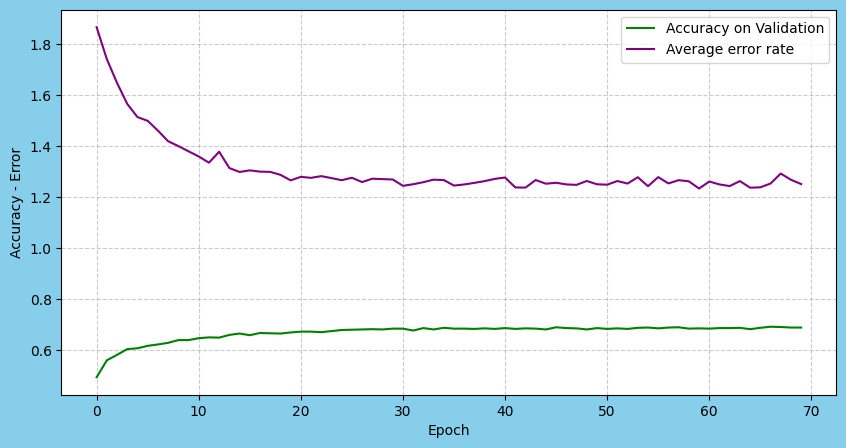

In [ ]:
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.grid(linestyle = '--',c = 'gray',alpha = 0.4)
some_ax.plot(the_scores,c = 'green',label = 'Accuracy on Validation')
some_ax.plot(the_losses,color = 'purple',label  = 'Average error rate')
some_ax.set_ylabel('Accuracy - Error')
some_ax.set_xlabel('Epoch')
some_ax.legend()

In [ ]:
some_figure.savefig('/home/luchian/all_data/uni_data/val_48.png')

In [ ]:
ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_100_embeddings.pth',weights_only = True))
ngramcnnmod = NgramCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=100,ker_sizes=[2,4,5])
ngramcnnmod.embed.weight = ngram_model.embed.weight
print(ngramcnnmod.embed)
ngramcnnmod.to(device = 'cuda')

Embedding(57568, 100, padding_idx=1)


NgramCNNMod(
  (embed): Embedding(57568, 100, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 100), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 100), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 100), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=45)
epoch = 25
lr = 0.00005
optimizer = torch.optim.Adam(lr = lr,params = ngramcnnmod.parameters(),betas = (0.9,0.99))

In [ ]:
final_cnn_ngram_100 = train_classification_model(ngramcnnmod,epoch,train_loader,optimizer,loss_func,TestDataset,dev = 'cuda')

Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.12it/s]


Epoch # 1 | Loss: 1.899601865044007 | Val acc: 0.37408 | Best acc on epoch #1



Going through the loader: 100%|██████████| 520/520 [00:43<00:00, 12.04it/s]


Epoch # 2 | Loss: 1.817601461135424 | Val acc: 0.4315 | Best acc on epoch #2



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.46it/s]


Epoch # 3 | Loss: 1.7601632396762188 | Val acc: 0.4548 | Best acc on epoch #3



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.61it/s]


Epoch # 4 | Loss: 1.7186798946215556 | Val acc: 0.45139 | Best acc on epoch #3



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.29it/s]


Epoch # 5 | Loss: 1.6766660290268751 | Val acc: 0.46731 | Best acc on epoch #5



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.32it/s]


Epoch # 6 | Loss: 1.666257315644851 | Val acc: 0.45765 | Best acc on epoch #5



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.62it/s]


Epoch # 7 | Loss: 1.6337176936177107 | Val acc: 0.47243 | Best acc on epoch #7



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.30it/s]


Epoch # 8 | Loss: 1.5974375266295213 | Val acc: 0.47698 | Best acc on epoch #8



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.19it/s]


Epoch # 9 | Loss: 1.579207618190692 | Val acc: 0.47641 | Best acc on epoch #8



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.25it/s]


Epoch # 10 | Loss: 1.5791923078206869 | Val acc: 0.47527 | Best acc on epoch #8



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.36it/s]


Epoch # 11 | Loss: 1.5658939520900066 | Val acc: 0.47811 | Best acc on epoch #11



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.26it/s]


Epoch # 12 | Loss: 1.5525419179063578 | Val acc: 0.48039 | Best acc on epoch #12



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.27it/s]


Epoch # 13 | Loss: 1.4902894253914172 | Val acc: 0.47925 | Best acc on epoch #12



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.32it/s]


Epoch # 14 | Loss: 1.5104087794056305 | Val acc: 0.47925 | Best acc on epoch #12



Going through the loader: 100%|██████████| 520/520 [00:43<00:00, 12.08it/s]


Epoch # 15 | Loss: 1.4911682434953175 | Val acc: 0.47982 | Best acc on epoch #15



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.24it/s]


Epoch # 16 | Loss: 1.4871607064054562 | Val acc: 0.48209 | Best acc on epoch #16



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.18it/s]


Epoch # 17 | Loss: 1.4953259321359487 | Val acc: 0.48039 | Best acc on epoch #16



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.45it/s]


Epoch # 18 | Loss: 1.4827568783209875 | Val acc: 0.48152 | Best acc on epoch #18



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.33it/s]


Epoch # 19 | Loss: 1.4648281867687518 | Val acc: 0.4838 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.24it/s]


Epoch # 20 | Loss: 1.4748991367622064 | Val acc: 0.48266 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.20it/s]


Epoch # 21 | Loss: 1.4761326182347076 | Val acc: 0.4838 | Best acc on epoch #21



Going through the loader: 100%|██████████| 520/520 [00:42<00:00, 12.25it/s]


Epoch # 22 | Loss: 1.463422204554081 | Val acc: 0.48607 | Best acc on epoch #22



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.45it/s]


Epoch # 23 | Loss: 1.4445023076465497 | Val acc: 0.48493 | Best acc on epoch #22



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.47it/s]


Epoch # 24 | Loss: 1.449032515172775 | Val acc: 0.4855 | Best acc on epoch #24



Going through the loader: 100%|██████████| 520/520 [00:41<00:00, 12.46it/s]


Epoch # 25 | Loss: 1.4261510462141953 | Val acc: 0.48493 | Best acc on epoch #24



In [ ]:
the_losses = final_cnn_ngram_100[1]
the_scores = final_cnn_ngram_100[2]

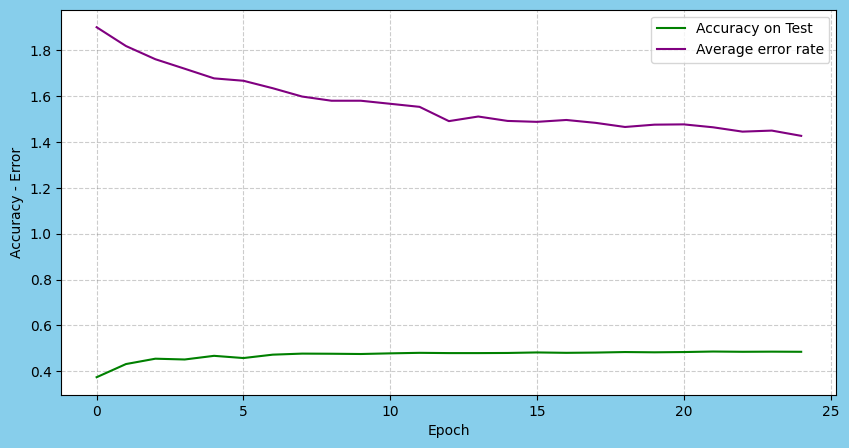

In [ ]:
some_figure = plt.figure(figsize = (10,5),facecolor = 'skyblue')
some_ax = some_figure.add_subplot()
some_ax.grid(linestyle = '--',c = 'gray',alpha = 0.4)
some_ax.plot(the_scores,c = 'green',label = 'Accuracy on Test')
some_ax.plot(the_losses,color = 'purple',label  = 'Average error rate')
some_ax.set_ylabel('Accuracy - Error')
some_ax.set_xlabel('Epoch')
some_ax.legend()

In [ ]:
some_figure.savefig('/home/luchian/all_data/uni_data/test_48.png')

In [ ]:
# torch.save(ngramcnnmod.state_dict(),'/home/luchian/all_data/uni_data/NgramCNNmod_acc_48.pth')
# ngramcnnmod.load_state_dict(torch.load('/home/luchian/all_data/uni_data/NgramCNNmod_acc_48.pth',weights_only=True))

<All keys matched successfully>

In [ ]:
# get_accuracy(ngramcnnmod,TestDataset)

0.48493

In [ ]:
##############################################RECAP
#CBOW
#NGRAM
#GloVe
#300 embedding dimension

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

In [ ]:
#DATASETS CLASSES

#Embedding Datasest
class NGramDataset(Dataset):
    def __init__(self,tokenizer,the_data):
        self.main_data = the_data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.main_data)

    def __getitem__(self,indx):
        X = torch.tensor([self.tokenizer.token_to_id(word) if self.tokenizer.token_to_id(word) != None else self.tokenizer.token_to_id('[UNK]') for word in self.main_data[indx][0]],dtype=torch.long)
        true_word = self.main_data[indx][1]
        y = self.tokenizer.token_to_id(true_word) if self.tokenizer.token_to_id(true_word) != None else self.tokenizer.token_to_id('[UNK]')
        return X,y

#News Dataset
class NewsDataset(Dataset):
    def __init__(self,the_data,le,tokenizer,transforms = None):
        self.main_data = the_data
        self.tokenizer = tokenizer
        self.label_encoder = le
        self.transforms = transforms

    def __len__(self):
        return len(self.main_data)

    def __getitem__(self,indx):
        X = [self.tokenizer.token_to_id(one_token) if self.tokenizer.token_to_id(one_token) != None else self.tokenizer.token_to_id('[UNK]') for one_token in normalize_text(self.main_data.iloc[indx,0])]
        y = self.label_encoder.transform([self.main_data.iloc[indx,1]]).item()
        X,y = torch.tensor(X,dtype = torch.long),torch.tensor(y,dtype = torch.long)
        return (X,y) if self.transforms == None else (self.transforms(X),y)

In [ ]:
#DIFFERENT MODELS


#EmbedCNNMod
class EmbedCNNMod(nn.Module):
    def __init__(self,vocab_size,dim_embed = 300,ker_sizes = [2,4,5]):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed,padding_idx=1)
        self.conv1 = nn.Conv2d(1,111,kernel_size=(ker_sizes[0],dim_embed))
        self.conv2 = nn.Conv2d(1,111,kernel_size=(ker_sizes[1],dim_embed))
        self.conv3 = nn.Conv2d(1,111,kernel_size=(ker_sizes[2],dim_embed))
        self.lin1 = nn.Linear(333,7)

        self.mp1 = nn.MaxPool1d(kernel_size=945-ker_sizes[0]+1)
        self.mp2 = nn.MaxPool1d(kernel_size=945-ker_sizes[1]+1)
        self.mp3 = nn.MaxPool1d(kernel_size=945-ker_sizes[2]+1)
        self.drop = nn.Dropout1d(p = 0.5)

        self.rel = nn.ReLU()

    def forward(self,inds_list):
        y = self.embed(inds_list)
        y = y.unsqueeze(dim = 1)

        y1 = self.rel(self.conv1(y))
        y2 = self.rel(self.conv2(y))
        y3 = self.rel(self.conv3(y))

        y1 = y1.squeeze(dim = -1)
        y2 = y2.squeeze(dim = -1)
        y3 = y3.squeeze(dim = -1)

        y1 = self.mp1(y1)
        y2 = self.mp2(y2)
        y3 = self.mp3(y3)

        y = torch.concat([y1,y2,y3],dim = -1)
        y = y.reshape(y.shape[0],-1)
        y = self.drop(y)
        y = self.rel(self.lin1(y))
        return y


#ngram model
class NGramModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        #from both sides
        self.linear1 = nn.Linear(2*window_size*dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list)
        y = y.reshape(y.shape[0],-1)
        y = self.rel(self.linear1(y))
        y = self.rel(self.linear2(y))
        return y

#CBOW model
class CBOWModel(nn.Module):
    def __init__(self,vocab_size,dim_embed,window_size = 2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,dim_embed)
        self.linear1 = nn.Linear(dim_embed,128)
        self.linear2 = nn.Linear(128,vocab_size)
        self.rel = nn.ReLU()

    def forward(self,ind_list):
        y = self.embed(ind_list).sum(dim = 1)
        y = self.rel(self.linear1(y))
        y = self.rel(self.linear2(y))
        return y

In [ ]:
#MAIN FUNCTIONS



#function for training the classification model
def train_classification_model(the_model,epoch,loader,optimizer,loss_func,val_dataset,dev = 'cuda',model_name = 'some_name'):
    average_ep_losses = []
    best_epoch = None
    val_accs = []
    try:
        for one_ep in range(epoch):
            torch.save(the_model.state_dict(), model_name + f'_weights.pth')
            torch.save(optimizer.state_dict(),model_name + f'_optim.pth')
            shutil.copy('/content/' + model_name + f'_weights.pth','/content/drive/MyDrive')
            shutil.copy('/content/' + model_name + f'_optim.pth','/content/drive/MyDrive')
            the_model.train()
            the_losses = []
            for X,y in tqdm(loader,desc = 'Going through the loader'):
                X,y = X.to(device = dev),y.to(device = dev)
                optimizer.zero_grad()
                y_pred = the_model(X)
                the_loss = loss_func(y_pred,y)
                the_loss.backward()
                the_losses.append(the_loss.item())
                optimizer.step()
            if one_ep%1== 0:
                avg_loss = np.array(the_losses).mean()
                average_ep_losses.append(avg_loss)
                val_score = get_accuracy(the_model,val_dataset,dev =dev)
                val_accs.append(val_score)

                if best_epoch == None:
                    best_epoch = one_ep + 1
                else:
                    best_epoch = one_ep + 1 if val_accs[-1] > val_accs[-2] else best_epoch

                print(f'Epoch # {one_ep+1} | Loss: {avg_loss} | Val acc: {val_score} | Best acc on epoch #{best_epoch}',end = '\n\n')
        return best_epoch,average_ep_losses,val_accs
    except KeyboardInterrupt:
        return best_epoch,average_ep_losses,val_accs

def train_ngram_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda',save_path = '1'):
    for one_ep in range(epoch):
        the_model.train()
        torch.save(the_model.state_dict(),save_path + f'_epoch_#{one_ep+1}.pth')
        shutil.copy(save_path + f'_epoch_#{one_ep+1}.pth','/content/drive/MyDrive')
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

def train_cbow_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda',name = '1'):
    for one_ep in range(epoch):
        # torch.save(the_model.state_dict(),name+f'_epoch#{one_ep+1}.pth')
        # shutil.copy('/content/'+name+f'_epoch#{one_ep+1}.pth','/content/drive/MyDrive')
        the_model.train()
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

class Padding():
    def __init__(self,pad = 945,dtype = torch.long):
        self.pad = pad
        self.dtype = dtype
    def __call__(self,tens):
        ones = torch.ones(self.pad,dtype = self.dtype)
        for ind in range(tens.shape[0]):
            ones[ind] = tens[ind]
        return ones
#accuracy score
@torch.no_grad()
def get_accuracy(model,dataset,dev = 'cuda'):
    model.eval()
    model.to(device = dev)

    N = len(dataset)
    correct = 0

    the_loader = DataLoader(dataset = dataset,shuffle=True,batch_size=1)
    for X,y in the_loader:
        X,y = X.to(device= dev),y.to(device= dev)
        y_pred = model(X).softmax(dim = 1).argmax(dim = 1).item()
        y = y.item()
        if y == y_pred:
            correct += 1
    return round(correct/N,5)


#text normalization
def normalize_text(the_text):
    lowered = the_text.lower()
    found = re.findall(r'[А-я0-9A-z]+',lowered)
    filtered_found = [word for word in found if word != '' and word not in russian_stopwords]
    return filtered_found


def cleared_texts(text_col):
    for ith_row in range(len(text_col)):
        for token in normalize_text(text_col.iloc[ith_row]):
            yield token

import nltk
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')
print(len(russian_stopwords))
russian_stopwords[:10]

151


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#LOADING

#some variables that need to be saved
the_max_len_of_sents = 945

#loading saved tokenizers

with open('Train_tokenizer.pkl','rb') as file:
    Train_tokenizer = pickle.load(file)

with open('Test_tokenizer.pkl','rb') as file:
    Test_tokenizer = pickle.load(file)

#loading datasets
Train_news,Test_news = pd.read_csv('Train_news.csv',index_col=0),pd.read_csv('Test_news.csv',index_col=0)

#load dataset for ngram and cbow models
# with open('Train_Ngramsdataset','rb') as file:
#     Train_Ngramsdataset = pickle.load(file)

#loading labels
unique_train_labels = Train_news['topic'].unique()
le = preprocessing.LabelEncoder().fit(unique_train_labels)
print(le.classes_)

#loading torhch datasets
TrainDataset = NewsDataset(Train_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))
TestDataset = NewsDataset(Test_news,le,Train_tokenizer,transforms=Padding(the_max_len_of_sents))

#computing classes
the_classes = []
for X,y in TrainDataset:
    the_classes.append(int(y))

#Train and Validation
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.96,0.04])
print(len(MainTrain),len(MainVal))

#TRAINING NGRAM model
vocab_size = Train_tokenizer.get_vocab_size()
ngram_model = NGramModel(vocab_size,dim_embed = 300,window_size = 2)
ngram_model.load_state_dict(torch.load('ngram_300_embeddings_epoch#9.pth'))
ngram_model.to(device = 'cuda')

#TRAINING THE CBOW MODEL
vocab_size = Train_tokenizer.get_vocab_size()
cbow_model = CBOWModel(vocab_size,dim_embed = 300,window_size = 2)
cbow_model.to(device = 'cuda')

the_weights = compute_class_weight(class_weight= 'balanced',classes=np.unique(the_classes),y=np.array(the_classes))
scaled_weights = the_weights/the_weights.sum()
torch_train_weights = torch.tensor(scaled_weights,dtype = torch.float32)
print(torch_train_weights)

['Бизнес' 'Интернет и СМИ' 'Культура' 'Политика' 'Спорт' 'Финансы'
 'Экономика']
22430 934
tensor([0.2881, 0.0106, 0.0111, 0.3776, 0.0111, 0.2908, 0.0107])


In [ ]:
#train RNN model
import shutil
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
TestDataset

In [ ]:
#TRAINING NGRAM model
vocab_size = Train_tokenizer.get_vocab_size()
ngram_model = NGramModel(vocab_size,dim_embed = 300,window_size = 2)
ngram_model.load_state_dict(torch.load('ngram_300_embeddings_epoch#9.pth'))
ngram_model.to(device = 'cuda')

NGramModel(
  (embed): Embedding(57568, 300)
  (linear1): Linear(in_features=1200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=57568, bias=True)
  (rel): ReLU()
)

In [ ]:
train_loader_ngram_300 = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 50)
lr = 0.01
epoch = 50
optimizer_ngram_300 = torch.optim.SGD(lr = lr,params= ngram_model.parameters(),momentum=0.003)
the_loss = nn.CrossEntropyLoss()

In [ ]:
train_ngram_model(ngram_model,epoch,train_loader_ngram_300,optimizer_ngram_300,the_loss,dev = 'cuda',save_path='ngram_300_embd')

Going through the loader: 100%|██████████| 63074/63074 [05:59<00:00, 175.33it/s]


Current Loss: 7.563662950648681


Going through the loader: 100%|██████████| 63074/63074 [05:58<00:00, 175.76it/s]


Current Loss: 7.473196899573003


Going through the loader: 100%|██████████| 63074/63074 [05:58<00:00, 175.77it/s]


Current Loss: 7.39144091339727


Going through the loader:  26%|██▌       | 16119/63074 [01:31<04:27, 175.58it/s]


KeyboardInterrupt: 

In [ ]:
ngram_model.embed.weight

Parameter containing:
tensor([[ 1.3659, -2.8150, -0.2000,  ..., -0.0336,  0.1677,  0.1674],
        [ 0.6954, -0.7205,  1.4831,  ...,  0.7945, -0.1423,  1.7137],
        [-0.4511,  2.2922, -0.1229,  ..., -0.7608,  0.2399, -0.3266],
        ...,
        [-0.5674, -0.0741,  1.0345,  ..., -0.6890,  2.0786,  1.2053],
        [-0.4949,  0.5707,  1.4642,  ..., -1.8230, -0.6479, -2.0905],
        [ 1.9205,  0.7837,  1.4448,  ..., -1.3438,  0.3314,  0.1270]],
       device='cuda:0', requires_grad=True)

In [ ]:
ngram_300_cnn_mod.embed.weight

Parameter containing:
tensor([[ 1.3659, -2.8150, -0.2000,  ..., -0.0336,  0.1677,  0.1674],
        [ 0.6954, -0.7205,  1.4831,  ...,  0.7945, -0.1423,  1.7137],
        [-0.4511,  2.2922, -0.1229,  ..., -0.7608,  0.2399, -0.3266],
        ...,
        [-0.5674, -0.0741,  1.0345,  ..., -0.6890,  2.0786,  1.2053],
        [-0.4949,  0.5707,  1.4642,  ..., -1.8230, -0.6479, -2.0905],
        [ 1.9205,  0.7837,  1.4448,  ..., -1.3438,  0.3314,  0.1270]],
       device='cuda:0', requires_grad=True)

In [ ]:
ngram_model.embed.weight

Parameter containing:
tensor([[ 1.4102, -2.8383, -0.1999,  ..., -0.0044,  0.1707,  0.1765],
        [ 0.6954, -0.7205,  1.4831,  ...,  0.7945, -0.1423,  1.7137],
        [-0.4291,  2.2864, -0.1041,  ..., -0.7374,  0.2459, -0.3318],
        ...,
        [-0.5669, -0.0742,  1.0345,  ..., -0.6892,  2.0789,  1.2048],
        [-0.4950,  0.5708,  1.4642,  ..., -1.8229, -0.6479, -2.0906],
        [ 1.9204,  0.7839,  1.4448,  ..., -1.3438,  0.3315,  0.1269]],
       device='cuda:0', requires_grad=True)

In [ ]:
# torch.save(ngram_model.state_dict(),'/home/luchian/all_data/uni_data/ngram_300_embeddings.pth')
# torch.save(optimizer_ngram_300.state_dict(),'/home/luchian/all_data/uni_data/optimizer_ngram_300.pth')
# optimizer_ngram_300.load_state_dict(torch.load('/home/luchian/all_data/uni_data/optimizer_ngram_300.pth',weights_only=True))
# ngram_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/ngram_300_embeddings.pth',weights_only=True))

In [ ]:
ngram_model.load_state_dict(torch.load('ngram_300_embeddings_epoch#9.pth',weights_only=True))

<All keys matched successfully>

In [ ]:
ngram_300_cnn_mod = EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=300,ker_sizes=[2,4,5])
ngram_300_cnn_mod.embed.weight = ngram_model.embed.weight
ngram_300_cnn_mod.to(device = 'cuda')

EmbedCNNMod(
  (embed): Embedding(57568, 300, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 300), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 300), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 300), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [ ]:
torch_train_weights

tensor([0.2881, 0.0106, 0.0111, 0.3776, 0.0111, 0.2908, 0.0107])

In [ ]:
MainTrain,MainVal = random_split(TrainDataset,lengths=[0.96,0.04])
print(len(MainTrain),len(MainVal))

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader_ngram_cnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=45)
epoch = 50
lr = 0.00018
optimizer_ngram_cnn = torch.optim.Adam(lr = lr,params = ngram_300_cnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
res_300 = train_classification_model(ngram_300_cnn_mod,epoch,train_loader_ngram_cnn,optimizer_ngram_cnn,loss_func,TestDataset,dev = 'cuda')

Going through the loader: 100%|██████████| 520/520 [01:19<00:00,  6.53it/s]


Epoch # 1 | Loss: 1.7371953054116323 | Val acc: 0.66174 | Best acc on epoch #1



Going through the loader: 100%|██████████| 520/520 [01:37<00:00,  5.35it/s]


Epoch # 2 | Loss: 1.5886886874070534 | Val acc: 0.68675 | Best acc on epoch #2



Going through the loader:  12%|█▏        | 64/520 [00:10<01:14,  6.11it/s]


In [ ]:
res_300 = train_classification_model(ngram_300_cnn_mod,epoch,train_loader_ngram_cnn,optimizer_ngram_cnn,loss_func,TestDataset,dev = 'cuda',name = 'ngram_300_cnn_mod')

Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.80it/s]


Epoch # 1 | Loss: 1.5377959073736118 | Val acc: 0.70097 | Best acc on epoch #1



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.84it/s]


Epoch # 2 | Loss: 1.518867476284504 | Val acc: 0.70779 | Best acc on epoch #2



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.84it/s]


Epoch # 3 | Loss: 1.4941373693255278 | Val acc: 0.70495 | Best acc on epoch #2



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.84it/s]


Epoch # 4 | Loss: 1.4974161794552436 | Val acc: 0.70836 | Best acc on epoch #4



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.84it/s]


Epoch # 5 | Loss: 1.4726579619141726 | Val acc: 0.71063 | Best acc on epoch #5



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.88it/s]


Epoch # 6 | Loss: 1.4802099130474604 | Val acc: 0.71063 | Best acc on epoch #5



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.89it/s]


Epoch # 7 | Loss: 1.4753667770670011 | Val acc: 0.71347 | Best acc on epoch #7



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.87it/s]


Epoch # 8 | Loss: 1.465437327669217 | Val acc: 0.71234 | Best acc on epoch #7



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.84it/s]


Epoch # 9 | Loss: 1.4630489930510522 | Val acc: 0.70779 | Best acc on epoch #7



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.82it/s]


Epoch # 10 | Loss: 1.4585303369622964 | Val acc: 0.7112 | Best acc on epoch #10



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 11 | Loss: 1.4639059846217817 | Val acc: 0.71518 | Best acc on epoch #11



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.84it/s]


Epoch # 12 | Loss: 1.4656148050840085 | Val acc: 0.71461 | Best acc on epoch #11



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 13 | Loss: 1.4652661685760204 | Val acc: 0.71518 | Best acc on epoch #13



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.88it/s]


Epoch # 14 | Loss: 1.4628936644930106 | Val acc: 0.71973 | Best acc on epoch #14



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.90it/s]


Epoch # 15 | Loss: 1.4572530835866928 | Val acc: 0.71745 | Best acc on epoch #14



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.91it/s]


Epoch # 16 | Loss: 1.4615464272407386 | Val acc: 0.71518 | Best acc on epoch #14



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 17 | Loss: 1.4560915044867075 | Val acc: 0.71461 | Best acc on epoch #14



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 18 | Loss: 1.4740671867361435 | Val acc: 0.70267 | Best acc on epoch #14



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 19 | Loss: 1.4708383003106484 | Val acc: 0.71347 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 20 | Loss: 1.459777830541134 | Val acc: 0.71291 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [01:16<00:00,  6.83it/s]


Epoch # 21 | Loss: 1.462345121571651 | Val acc: 0.71177 | Best acc on epoch #19



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.85it/s]


Epoch # 22 | Loss: 1.4593897869953742 | Val acc: 0.71802 | Best acc on epoch #22



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.89it/s]


Epoch # 23 | Loss: 1.466464194884667 | Val acc: 0.69471 | Best acc on epoch #22



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.91it/s]


Epoch # 24 | Loss: 1.4613977575531372 | Val acc: 0.71632 | Best acc on epoch #24



Going through the loader: 100%|██████████| 520/520 [01:15<00:00,  6.88it/s]


Epoch # 25 | Loss: 1.4636270651450525 | Val acc: 0.71234 | Best acc on epoch #24



Going through the loader:  28%|██▊       | 146/520 [00:21<00:55,  6.73it/s]


In [ ]:
def train_cbow_model(the_model,epoch,loader,optimizer,loss_func,dev = 'cuda',name = '1'):
    for one_ep in range(epoch):
        the_model.train()
        torch.save(the_model.state_dict(),name+f'_epoch#{one_ep+1}.pth')
        shutil.copy('/content/'+name+f'_epoch#{one_ep+1}.pth','/content/drive/MyDrive')
        the_losses = []
        for X,y in tqdm(loader,desc = 'Going through the loader'):
            X,y = X.to(device = 'cuda'),y.to(device = 'cuda')
            optimizer.zero_grad()
            y_pred = the_model(X)
            the_loss = loss_func(y_pred,y)
            the_loss.backward()
            the_losses.append(the_loss.item())
            optimizer.step()
        if one_ep%1== 0:
            print(f'Current Loss: {np.array(the_losses).mean()}')

In [ ]:
#TRAINING THE CBOW MODEL
vocab_size = Train_tokenizer.get_vocab_size()
cbow_model = CBOWModel(vocab_size,dim_embed = 300,window_size = 2)
cbow_model.to(device = 'cuda')

CBOWModel(
  (embed): Embedding(57568, 300)
  (linear1): Linear(in_features=300, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=57568, bias=True)
  (rel): ReLU()
)

In [ ]:
train_cbow_loader = DataLoader(dataset = Train_Ngramsdataset,shuffle = True,batch_size = 44)
lr = 0.002
epoch = 50
optimizer_cbow = torch.optim.SGD(lr = lr,params= cbow_model.parameters(),momentum=0.9)
the_loss = nn.CrossEntropyLoss()

In [ ]:
train_cbow_model(cbow_model,epoch,train_cbow_loader,optimizer_cbow,the_loss)

Going through the loader: 100%|██████████| 71675/71675 [06:43<00:00, 177.60it/s]


Current Loss: 7.6457652332677135


Going through the loader: 100%|██████████| 71675/71675 [06:41<00:00, 178.58it/s]


Current Loss: 7.577252092331513


Going through the loader: 100%|██████████| 71675/71675 [06:41<00:00, 178.67it/s]


Current Loss: 7.516658015143052


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.81it/s]


Current Loss: 7.4626910695507425


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.90it/s]


Current Loss: 7.413403981477906


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.86it/s]


Current Loss: 7.368448825765662


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.88it/s]


Current Loss: 7.326845649383939


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.87it/s]


Current Loss: 7.289064914316178


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.88it/s]


Current Loss: 7.253486025357521


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.91it/s]


Current Loss: 7.220635993686087


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.93it/s]


Current Loss: 7.1896440534821195


Going through the loader: 100%|██████████| 71675/71675 [06:40<00:00, 178.92it/s]


Current Loss: 7.160444252784551


Going through the loader: 100%|██████████| 71675/71675 [06:39<00:00, 179.24it/s]


Current Loss: 7.133070844571932


Going through the loader: 100%|██████████| 71675/71675 [06:39<00:00, 179.29it/s]


Current Loss: 7.106488306766027


Going through the loader:  39%|███▉      | 28206/71675 [02:37<03:58, 182.08it/s]

In [ ]:
cbow_model.load_state_dict(torch.load('cbow_300_768.pth'))

<All keys matched successfully>

In [ ]:
optimizer_cbow.load_state_dict(torch.load('optimizer_cbow_300.pth'))

In [ ]:
# torch.save(cbow_model.state_dict(),'cbow_300_768.pth')

In [ ]:
# torch.save(optimizer_cbow.state_dict(),'optimizer_cbow_300.pth')

In [ ]:
shutil.copy('/content/cbow_300_768.pth','/content/drive/MyDrive')

'/content/drive/MyDrive/cbow_300_768.pth'

In [ ]:
torch.save(cbow_model.state_dict(),'/home/luchian/all_data/uni_data/cbow_300_embeddings.pth')
# cbow_model.load_state_dict(torch.load('/home/luchian/all_data/uni_data/cbow_300_embeddings.pth',weights_only=True))

<All keys matched successfully>

In [ ]:
from google.colab import drive
import shutil

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shutil.copy('/content/drive/MyDrive/1_epoch#9.pth','/content')

'/content/1_epoch#9.pth'

In [ ]:
cbow_model.load_state_dict(torch.load('1_epoch#9.pth'))

<All keys matched successfully>

In [ ]:
cbow_300_cnn_mod = EmbedCNNMod(Train_tokenizer.get_vocab_size(),dim_embed=300,ker_sizes=[2,4,5])
cbow_300_cnn_mod.embed.weight = cbow_model.embed.weight
cbow_300_cnn_mod.to(device = 'cuda')

EmbedCNNMod(
  (embed): Embedding(57568, 300, padding_idx=1)
  (conv1): Conv2d(1, 111, kernel_size=(2, 300), stride=(1, 1))
  (conv2): Conv2d(1, 111, kernel_size=(4, 300), stride=(1, 1))
  (conv3): Conv2d(1, 111, kernel_size=(5, 300), stride=(1, 1))
  (lin1): Linear(in_features=333, out_features=7, bias=True)
  (mp1): MaxPool1d(kernel_size=944, stride=944, padding=0, dilation=1, ceil_mode=False)
  (mp2): MaxPool1d(kernel_size=942, stride=942, padding=0, dilation=1, ceil_mode=False)
  (mp3): MaxPool1d(kernel_size=941, stride=941, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout1d(p=0.5, inplace=False)
  (rel): ReLU()
)

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_loader_cbow_cnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=54)
epoch = 50
lr = 0.00018
optimizer_cbow_cnn = torch.optim.Adam(lr = lr,params = cbow_300_cnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
conv_300_cbow = train_classification_model(cbow_300_cnn_mod,epoch,train_loader_cbow_cnn,optimizer_cbow_cnn,loss_func,TestDataset,dev = 'cuda',name = 'cbow_300_cnn_mod')

Going through the loader: 100%|██████████| 433/433 [01:13<00:00,  5.86it/s]


Epoch # 1 | Loss: 1.7872708633920613 | Val acc: 0.46561 | Best acc on epoch #1



Going through the loader: 100%|██████████| 433/433 [01:14<00:00,  5.83it/s]


Epoch # 2 | Loss: 1.6919623236182655 | Val acc: 0.47413 | Best acc on epoch #2



Going through the loader: 100%|██████████| 433/433 [01:15<00:00,  5.76it/s]


Epoch # 3 | Loss: 1.6639294128770366 | Val acc: 0.47754 | Best acc on epoch #3



Going through the loader: 100%|██████████| 433/433 [01:14<00:00,  5.83it/s]


Epoch # 4 | Loss: 1.650169629422952 | Val acc: 0.47698 | Best acc on epoch #3



Going through the loader: 100%|██████████| 433/433 [01:14<00:00,  5.83it/s]


Epoch # 5 | Loss: 1.634396759522154 | Val acc: 0.69301 | Best acc on epoch #5



Going through the loader: 100%|██████████| 433/433 [01:15<00:00,  5.77it/s]


Epoch # 6 | Loss: 1.5448444981222615 | Val acc: 0.69471 | Best acc on epoch #6



Going through the loader: 100%|██████████| 433/433 [01:13<00:00,  5.86it/s]


Epoch # 7 | Loss: 1.5130650483708459 | Val acc: 0.69471 | Best acc on epoch #6



Going through the loader: 100%|██████████| 433/433 [01:13<00:00,  5.87it/s]


Epoch # 8 | Loss: 1.4969125898 | Val acc: 0.70097 | Best acc on epoch #8



Going through the loader: 100%|██████████| 433/433 [01:13<00:00,  5.86it/s]


Epoch # 9 | Loss: 1.495853586642902 | Val acc: 0.69812 | Best acc on epoch #8



Going through the loader: 100%|██████████| 433/433 [01:14<00:00,  5.84it/s]


Epoch # 10 | Loss: 1.4909717608544348 | Val acc: 0.69756 | Best acc on epoch #8



Going through the loader: 100%|██████████| 433/433 [01:13<00:00,  5.92it/s]


Epoch # 11 | Loss: 1.4836160029880445 | Val acc: 0.7004 | Best acc on epoch #11



Going through the loader: 100%|██████████| 433/433 [01:12<00:00,  5.93it/s]


Epoch # 12 | Loss: 1.4847066270286438 | Val acc: 0.7021 | Best acc on epoch #12



Going through the loader: 100%|██████████| 433/433 [01:13<00:00,  5.86it/s]


Epoch # 13 | Loss: 1.4869635116145463 | Val acc: 0.7021 | Best acc on epoch #12



Going through the loader:  37%|███▋      | 160/433 [00:27<00:46,  5.84it/s]


In [ ]:
cbow_model.embed.weight

Parameter containing:
tensor([[ 0.8923,  0.2823,  1.6961,  ...,  0.4819,  0.6554,  0.0037],
        [ 1.0951,  0.0896,  0.1751,  ...,  0.5630, -0.6344, -0.7872],
        [ 1.6584, -0.8401,  2.0352,  ..., -0.7075,  0.3497,  1.7035],
        ...,
        [-1.2508,  0.6922,  2.6085,  ...,  0.1162, -1.3933, -1.8674],
        [ 0.0645,  0.4786, -0.2017,  ...,  0.9205, -1.0670, -0.2744],
        [ 0.6435,  0.6379, -0.8072,  ..., -0.8439,  0.1033,  0.7897]],
       device='cuda:0', requires_grad=True)

In [ ]:
ngram_300_cnn_mod.embed.weight

Parameter containing:
tensor([[ 0.8923,  0.2823,  1.6961,  ...,  0.4819,  0.6554,  0.0037],
        [ 1.0951,  0.0896,  0.1751,  ...,  0.5630, -0.6344, -0.7872],
        [ 1.6584, -0.8401,  2.0352,  ..., -0.7075,  0.3497,  1.7035],
        ...,
        [-1.2508,  0.6922,  2.6085,  ...,  0.1162, -1.3933, -1.8674],
        [ 0.0645,  0.4786, -0.2017,  ...,  0.9205, -1.0670, -0.2744],
        [ 0.6435,  0.6379, -0.8072,  ..., -0.8439,  0.1033,  0.7897]],
       device='cuda:0', requires_grad=True)

In [ ]:
#train RNN model
import shutil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Train RNN's
class RNNMod(nn.Module):
    def __init__(self,vocab_size,embed_dim,hid_size = 150,bi = False):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim)
        self.lstm1 = nn.LSTM(input_size = embed_dim,hidden_size = hid_size,batch_first = True,bidirectional = bi)
        self.lin = nn.Linear(2*hid_size if bi else hid_size,7)

    def forward(self,inds_list):
        y = self.embed(inds_list)
        _,(y,_) = self.lstm1(y)
        y = y.transpose(0,1)
        y = y.reshape(y.shape[0],-1)
        y = self.lin(y)
        return y

In [ ]:
#CBOW embeddings
cbow_300_rnn_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=300,bi = True)
cbow_model.load_state_dict(torch.load('1_epoch#15.pth',weights_only=True))
cbow_300_rnn_mod.embed.weight = cbow_model.embed.weight
cbow_300_rnn_mod.to(device = 'cuda')

RNNMod(
  (embed): Embedding(57568, 300)
  (lstm1): LSTM(300, 150, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=300, out_features=7, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_cbow_rnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 16
lr = 5*10**-5
optimizer_main_cbow_rnn = torch.optim.Adam(lr = lr,params = cbow_300_rnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
cbow_rnn_res = train_classification_model(cbow_300_rnn_mod,
                           epoch,
                           train_main_cbow_rnn,
                           optimizer_main_cbow_rnn,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'cbow_300_RNN')

Going through the loader: 100%|██████████| 2337/2337 [02:09<00:00, 17.98it/s]


Epoch # 1 | Loss: 1.7005779564406152 | Val acc: 0.61001 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.94it/s]


Epoch # 2 | Loss: 1.3237715329836208 | Val acc: 0.68164 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.96it/s]


Epoch # 3 | Loss: 1.086651446666787 | Val acc: 0.78056 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [02:11<00:00, 17.83it/s]


Epoch # 4 | Loss: 0.8619894086613225 | Val acc: 0.81524 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.88it/s]


Epoch # 5 | Loss: 0.7380270561825837 | Val acc: 0.84196 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.93it/s]


Epoch # 6 | Loss: 0.6117316604530934 | Val acc: 0.84764 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.94it/s]


Epoch # 7 | Loss: 0.5115625374600974 | Val acc: 0.87152 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.97it/s]


Epoch # 8 | Loss: 0.4313937889174532 | Val acc: 0.86356 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [02:08<00:00, 18.14it/s]


Epoch # 9 | Loss: 0.3764847248448334 | Val acc: 0.88744 | Best acc on epoch #9



Going through the loader: 100%|██████████| 2337/2337 [02:09<00:00, 18.05it/s]


Epoch # 10 | Loss: 0.3231533448294341 | Val acc: 0.89085 | Best acc on epoch #10



Going through the loader: 100%|██████████| 2337/2337 [02:09<00:00, 18.04it/s]


Epoch # 11 | Loss: 0.27604942651968456 | Val acc: 0.89824 | Best acc on epoch #11



Going through the loader: 100%|██████████| 2337/2337 [02:08<00:00, 18.15it/s]


Epoch # 12 | Loss: 0.23650136516996567 | Val acc: 0.90108 | Best acc on epoch #12



Going through the loader: 100%|██████████| 2337/2337 [02:08<00:00, 18.18it/s]


Epoch # 13 | Loss: 0.20106007423736857 | Val acc: 0.89881 | Best acc on epoch #12



Going through the loader: 100%|██████████| 2337/2337 [02:12<00:00, 17.63it/s]


Epoch # 14 | Loss: 0.1673043679000047 | Val acc: 0.90108 | Best acc on epoch #14



Going through the loader: 100%|██████████| 2337/2337 [02:09<00:00, 17.99it/s]


Epoch # 15 | Loss: 0.14012585868054717 | Val acc: 0.91074 | Best acc on epoch #15



Going through the loader: 100%|██████████| 2337/2337 [02:10<00:00, 17.85it/s]


Epoch # 16 | Loss: 0.11325588424286176 | Val acc: 0.90165 | Best acc on epoch #15



In [ ]:
#GloVE emebddding for rnn
class GloveModel(nn.Module):
    def __init__(self,vocab_size,embed_dim = 150,dev = 'cuda'):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,embed_dim,padding_idx = 1)
        self.bias = torch.randn(1).to(device = dev)

    def forward(self,inds_tensor):
        ind1 = inds_tensor[:1]
        ind2 = inds_tensor[1:]
        vec1 = self.embed(ind1).reshape(-1)
        vec2 = self.embed(ind2).reshape(-1)
        return vec1.dot(vec2) + self.bias

In [ ]:
glove_mod = GloveModel(Train_tokenizer.get_vocab_size(),embed_dim=150)

In [ ]:
#model for glove emebeddings
glove_150_rnn_mod = RNNMod(Train_tokenizer.get_vocab_size(),embed_dim=150,bi = True)
glove_mod.load_state_dict(torch.load('glove_model_weights.pth',weights_only = True))
glove_150_rnn_mod.embed.weight = glove_mod.embed.weight
glove_150_rnn_mod.to(device = 'cuda')

RNNMod(
  (embed): Embedding(57568, 150)
  (lstm1): LSTM(150, 150, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=300, out_features=7, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_glove_rnn = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 16
lr = 5*10**-5
optimizer_main_glove_rnn = torch.optim.Adam(lr = lr,params = glove_150_rnn_mod.parameters(),betas = (0.9,0.99))

In [ ]:
glove_rnn_res = train_classification_model(glove_150_rnn_mod,
                           epoch,
                           train_main_glove_rnn,
                           optimizer_main_glove_rnn,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'glove_150_RNN')

Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.89it/s]


Epoch # 1 | Loss: 1.791263664692041 | Val acc: 0.46561 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.82it/s]


Epoch # 2 | Loss: 1.5180272077922388 | Val acc: 0.58044 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.85it/s]


Epoch # 3 | Loss: 1.35778653217423 | Val acc: 0.66174 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [02:05<00:00, 18.67it/s]


Epoch # 4 | Loss: 1.2071082880214385 | Val acc: 0.73792 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.86it/s]


Epoch # 5 | Loss: 1.0199635942419931 | Val acc: 0.78511 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.84it/s]


Epoch # 6 | Loss: 0.8475257706759473 | Val acc: 0.81808 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.76it/s]


Epoch # 7 | Loss: 0.7188071876215945 | Val acc: 0.805 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.98it/s]


Epoch # 8 | Loss: 0.6177355804714539 | Val acc: 0.84252 | Best acc on epoch #8



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.13it/s]


Epoch # 9 | Loss: 0.5448446827544123 | Val acc: 0.85105 | Best acc on epoch #9



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.79it/s]


Epoch # 10 | Loss: 0.4772516860410246 | Val acc: 0.86242 | Best acc on epoch #10



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.08it/s]


Epoch # 11 | Loss: 0.42444277651309903 | Val acc: 0.87777 | Best acc on epoch #11



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.05it/s]


Epoch # 12 | Loss: 0.3947294387644795 | Val acc: 0.87948 | Best acc on epoch #12



Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.95it/s]


Epoch # 13 | Loss: 0.3521598075999917 | Val acc: 0.88573 | Best acc on epoch #13



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.11it/s]


Epoch # 14 | Loss: 0.32567439485436156 | Val acc: 0.88744 | Best acc on epoch #14



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.08it/s]


Epoch # 15 | Loss: 0.292890365235906 | Val acc: 0.89255 | Best acc on epoch #15



Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.97it/s]


Epoch # 16 | Loss: 0.2630231973246277 | Val acc: 0.90279 | Best acc on epoch #16



In [ ]:
glove_rnn_res_2 = train_classification_model(glove_150_rnn_mod,
                           10,
                           train_main_glove_rnn,
                           optimizer_main_glove_rnn,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'glove_150_RNN')

Going through the loader: 100%|██████████| 2337/2337 [02:07<00:00, 18.28it/s]


Epoch # 1 | Loss: 0.2363738746611042 | Val acc: 0.90335 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.81it/s]


Epoch # 2 | Loss: 0.21353900184019783 | Val acc: 0.89937 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.09it/s]


Epoch # 3 | Loss: 0.19042110195808643 | Val acc: 0.91018 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [02:01<00:00, 19.25it/s]


Epoch # 4 | Loss: 0.16630949713634452 | Val acc: 0.90392 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.05it/s]


Epoch # 5 | Loss: 0.1435808470527688 | Val acc: 0.90847 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.72it/s]


Epoch # 6 | Loss: 0.1260590226511811 | Val acc: 0.90733 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.01it/s]


Epoch # 7 | Loss: 0.10662054958502026 | Val acc: 0.91018 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [02:04<00:00, 18.80it/s]


Epoch # 8 | Loss: 0.09881336419706846 | Val acc: 0.90847 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [02:02<00:00, 19.01it/s]


Epoch # 9 | Loss: 0.0810967491233102 | Val acc: 0.89937 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [02:03<00:00, 18.95it/s]


Epoch # 10 | Loss: 0.07799305652368257 | Val acc: 0.91188 | Best acc on epoch #10



In [ ]:
#train RNN model
import shutil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class PositionalEncoding():
    @torch.no_grad()
    def __init__(self,vocab_size,embed_dim,calc = True,dev = 'cuda'):
        '''Calculates the positional ecnodings'''
        self.d_model = embed_dim
        self.pos_embed = nn.Embedding(vocab_size,embed_dim).to(device = dev)
        if calc == True:
            for ind in range(vocab_size):
                pos_tensor = torch.tensor([
                    math.sin((ind+1)/10_000**(2*i/self.d_model))
                    if i%2 == 0
                    else
                    math.cos((ind+1)/10_000**(2*i/self.d_model))
                    for i in range(self.d_model)
                ])
                self.pos_embed.weight[ind] = pos_tensor
        else:
            pass

    def __call__(self,the_inds):
        return self.pos_embed(the_inds)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self,d_mod = 300,nhead = 6,encoder_layers = 6,batch_first = True,dev = 'cuda',vocab_size = Train_tokenizer.get_vocab_size()):
        super().__init__()
        self.embed = nn.Embedding(vocab_size,d_mod)
        self.single_encoder = nn.TransformerEncoderLayer(d_model = d_mod,nhead=nhead,batch_first = batch_first)
        self.full_encoder = nn.TransformerEncoder(encoder_layer = self.single_encoder,num_layers = encoder_layers)
        self.pos_encoder = PositionalEncoding(vocab_size = vocab_size,embed_dim = d_mod,calc = True,dev = dev)
        self.rnn = nn.RNN(input_size=d_mod,hidden_size=100,batch_first=batch_first)
        self.linear = nn.Linear(100,7)
    def forward(self,the_inds):
        embeds = self.embed(the_inds)
        pos_encodings = self.pos_encoder(the_inds)
        final_embed = embeds + pos_encodings
        y = self.full_encoder(final_embed)
        _,y = self.rnn(y)
        y = y.squeeze(dim = 0)
        y = self.linear(y)
        return y


In [ ]:
#Train Transformer model with skip_gram embeddings
ngram_300_transformer_mod = TransformerModel(d_mod = 300,
                               nhead = 6,
                               encoder_layers = 3,
                               batch_first = True,
                               dev = 'cuda',
                               vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda')
ngram_model.load_state_dict(torch.load('ngram_300_embeddings_epoch#9.pth',weights_only=True))
ngram_300_transformer_mod.embed.weight = ngram_model.embed.weight
ngram_300_transformer_mod.to(device = 'cuda')

TransformerModel(
  (embed): Embedding(57568, 300)
  (single_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (linear1): Linear(in_features=300, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=300, bias=True)
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (full_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=2048, bias=True)
        (dropout): Dro

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_ngram_transformers = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 10
lr = 5*10**-5
optimizer_main_ngram_transformers = torch.optim.Adam(lr = lr,params = ngram_300_transformer_mod.parameters(),betas = (0.9,0.99))

In [ ]:
ngram_transformer_res = train_classification_model(ngram_300_transformer_mod,
                           epoch,
                           train_main_ngram_transformers,
                           optimizer_main_ngram_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'ngram_300_Transformer')

Going through the loader: 100%|██████████| 2337/2337 [07:58<00:00,  4.88it/s]


Epoch # 1 | Loss: 1.0362295611025458 | Val acc: 0.8465 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [07:44<00:00,  5.03it/s]


Epoch # 2 | Loss: 0.5636103363961912 | Val acc: 0.89596 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [07:44<00:00,  5.03it/s]


Epoch # 3 | Loss: 0.4418239163399814 | Val acc: 0.89028 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [07:43<00:00,  5.04it/s]


Epoch # 4 | Loss: 0.34265459661766934 | Val acc: 0.89312 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [07:41<00:00,  5.06it/s]


Epoch # 5 | Loss: 0.2773230812696849 | Val acc: 0.91302 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [07:42<00:00,  5.06it/s]


Epoch # 6 | Loss: 0.2185289620817948 | Val acc: 0.91814 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [07:41<00:00,  5.06it/s]


Epoch # 7 | Loss: 0.18599158989474382 | Val acc: 0.92496 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [07:42<00:00,  5.05it/s]


Epoch # 8 | Loss: 0.1491274279530312 | Val acc: 0.91643 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [07:42<00:00,  5.05it/s]


Epoch # 9 | Loss: 0.12406263933983298 | Val acc: 0.91188 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [07:42<00:00,  5.06it/s]


Epoch # 10 | Loss: 0.10631213139132491 | Val acc: 0.93007 | Best acc on epoch #10



In [ ]:
#Train Transformer model with cbow embeddings
cbow_300_transformer_mod = TransformerModel(d_mod = 300,
                               nhead = 6,
                               encoder_layers = 3,
                               batch_first = True,
                               dev = 'cuda',
                               vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda')
cbow_model.load_state_dict(torch.load('1_epoch#15.pth',weights_only=True))
cbow_300_transformer_mod.embed.weight = cbow_model.embed.weight
cbow_300_transformer_mod.to(device = 'cuda')

TransformerModel(
  (embed): Embedding(57568, 300)
  (single_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
    )
    (linear1): Linear(in_features=300, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=300, bias=True)
    (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (full_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=300, out_features=300, bias=True)
        )
        (linear1): Linear(in_features=300, out_features=2048, bias=True)
        (dropout): Dro

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_cbow_transformers = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 10
lr = 5*10**-5
optimizer_main_cbow_transformers = torch.optim.Adam(lr = lr,params = cbow_300_transformer_mod.parameters(),betas = (0.9,0.99))

In [ ]:
cbow_transformer_res = train_classification_model(cbow_300_transformer_mod,
                           epoch,
                           train_main_cbow_transformers,
                           optimizer_main_cbow_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'cbow_300_Transformer')

Going through the loader: 100%|██████████| 2337/2337 [07:39<00:00,  5.08it/s]


Epoch # 1 | Loss: 0.9095010369104303 | Val acc: 0.8755 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [07:40<00:00,  5.08it/s]


Epoch # 2 | Loss: 0.5207142167894834 | Val acc: 0.90335 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [07:39<00:00,  5.08it/s]


Epoch # 3 | Loss: 0.3951041136378527 | Val acc: 0.90392 | Best acc on epoch #3



Going through the loader: 100%|██████████| 2337/2337 [07:40<00:00,  5.08it/s]


Epoch # 4 | Loss: 0.29921456705659283 | Val acc: 0.90961 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [07:39<00:00,  5.09it/s]


Epoch # 5 | Loss: 0.24091874037271108 | Val acc: 0.92155 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [07:39<00:00,  5.09it/s]


Epoch # 6 | Loss: 0.18834824261052718 | Val acc: 0.91529 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [07:39<00:00,  5.09it/s]


Epoch # 7 | Loss: 0.14986604382592833 | Val acc: 0.92723 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [07:38<00:00,  5.09it/s]


Epoch # 8 | Loss: 0.12620792865773497 | Val acc: 0.92211 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [07:39<00:00,  5.09it/s]


Epoch # 9 | Loss: 0.11345505232027675 | Val acc: 0.9187 | Best acc on epoch #7



Going through the loader: 100%|██████████| 2337/2337 [07:38<00:00,  5.09it/s]


Epoch # 10 | Loss: 0.09425122779614707 | Val acc: 0.92325 | Best acc on epoch #10



In [ ]:
#Train Transformer model with glove embeddings
glove_150_transformer_mod = TransformerModel(d_mod = 150,
                               nhead = 6,
                               encoder_layers = 3,
                               batch_first = True,
                               dev = 'cuda',
                               vocab_size = Train_tokenizer.get_vocab_size()).to(device = 'cuda')
glove_mod.load_state_dict(torch.load('glove_model_weights.pth',weights_only = True))
glove_150_transformer_mod.embed.weight = glove_mod.embed.weight
glove_150_transformer_mod.to(device = 'cuda')

TransformerModel(
  (embed): Embedding(57568, 150)
  (single_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
    )
    (linear1): Linear(in_features=150, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=150, bias=True)
    (norm1): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (full_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
        )
        (linear1): Linear(in_features=150, out_features=2048, bias=True)
        (dropout): Dro

In [ ]:
loss_func = nn.CrossEntropyLoss(weight=torch_train_weights.to(device = 'cuda'),reduction='mean')
train_main_glove_transformers = DataLoader(dataset = TrainDataset,shuffle=True,batch_size=10)
epoch = 10
lr = 5*10**-5
optimizer_main_glove_transformers = torch.optim.Adam(lr = lr,params = glove_150_transformer_mod.parameters(),betas = (0.9,0.99))

In [ ]:
glove_transformer_res = train_classification_model(glove_150_transformer_mod,
                           epoch,
                           train_main_glove_transformers,
                           optimizer_main_glove_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'glove_150_Transformer')

Going through the loader: 100%|██████████| 2337/2337 [05:04<00:00,  7.66it/s]


Epoch # 1 | Loss: 1.2936079243997451 | Val acc: 0.73223 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.65it/s]


Epoch # 2 | Loss: 0.679430268233053 | Val acc: 0.87607 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.65it/s]


Epoch # 3 | Loss: 0.5208780756877767 | Val acc: 0.86754 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.65it/s]


Epoch # 4 | Loss: 0.4226155007328993 | Val acc: 0.8954 | Best acc on epoch #4



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.66it/s]


Epoch # 5 | Loss: 0.3576998507538647 | Val acc: 0.9079 | Best acc on epoch #5



Going through the loader: 100%|██████████| 2337/2337 [05:04<00:00,  7.66it/s]


Epoch # 6 | Loss: 0.30017208002282925 | Val acc: 0.91586 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.66it/s]


Epoch # 7 | Loss: 0.26939178313593715 | Val acc: 0.91472 | Best acc on epoch #6



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.66it/s]


Epoch # 8 | Loss: 0.21805088215451376 | Val acc: 0.91757 | Best acc on epoch #8



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.66it/s]


Epoch # 9 | Loss: 0.19557766889105999 | Val acc: 0.91472 | Best acc on epoch #8



Going through the loader: 100%|██████████| 2337/2337 [05:05<00:00,  7.65it/s]


Epoch # 10 | Loss: 0.1632829603817191 | Val acc: 0.91359 | Best acc on epoch #8



In [ ]:
glove_transformer_res_2 = train_classification_model(glove_150_transformer_mod,
                           epoch,
                           train_main_glove_transformers,
                           optimizer_main_glove_transformers,
                           loss_func,
                           TestDataset,
                           dev = 'cuda',
                           model_name = 'glove_150_Transformer')

Going through the loader: 100%|██████████| 2337/2337 [05:03<00:00,  7.70it/s]


Epoch # 1 | Loss: 0.14303133171928467 | Val acc: 0.91018 | Best acc on epoch #1



Going through the loader: 100%|██████████| 2337/2337 [05:04<00:00,  7.67it/s]


Epoch # 2 | Loss: 0.126832747300226 | Val acc: 0.91472 | Best acc on epoch #2



Going through the loader: 100%|██████████| 2337/2337 [05:04<00:00,  7.67it/s]


Epoch # 3 | Loss: 0.1129422509460162 | Val acc: 0.92155 | Best acc on epoch #3



Going through the loader:  85%|████████▌ | 1996/2337 [04:20<00:45,  7.49it/s]